<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [23]</a>'.</span>

In [1]:
import json
import os
import warnings
from pathlib import Path
from typing import Any

import equinox as eqx
import jax.numpy as jnp
import jax.profiler
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from einops import rearrange, repeat
from ipywidgets import interact
from jax import config, device_count, random
from jax.scipy.optimize import minimize
from numpyencoder import NumpyEncoder
from scipy import constants
from stamox.sample import bootstrap

from jackpot.algorithms import AlgorithmChoice
from jackpot.algorithms.base import Algorithm
from jackpot.config import Config, JaxPlatform
from jackpot.fitting import SaturatingExponential
from jackpot.models.base import Model
from jackpot.models.ising import IsingModel
from jackpot.modules import AutocorrelationData
from jackpot.primitives.autocorrelate import acf
from jackpot.primitives.utils import beta_to_temp
from jackpot.profile import Stopwatch
from jackpot.state import Measurement, State
from jackpot.typing import RNGKey
from jackpot.utils.map import filter_map
from jackpot.utils.pbar import make_scan
from jackpot.utils.random import EasyKey

%load_ext autoreload
%autoreload 2

In [2]:
PAPERMILL: bool = False
PAPERMILL_INPUT_PATH: str = ""
PAPERMILL_OUTPUT_PATH: str = ""

In [3]:
# base
JAX_PLATFORM: JaxPlatform = JaxPlatform.CPU
DO_PROFILING: bool = False
ENABLE_64_BIT: bool = False
DO_AUTOCORRELATION: bool = False
DO_MEASURE: bool = True
PLOT_STATES: bool = False
CHECK_THERMALISED: bool = True

# experiment
RNG_SEED: int = 0
SPIN: float = 0.5
DIMENSIONS: int = 2
SIZE: int = 32
TOTAL_SAMPLES: int = 384
N_SAMPLES_VECTORISE: int = 2
LOOP_N_TEMPS_Y: bool = False


# environment
INTERACTION_BILINEAR: float = 1.0
INTERACTION_BIQUADRATIC: float = 0.0
INTERACTION_ANISOTROPY: float = 0.0
INTERACTION_BICUBIC: float = 0.0
INTERACTION_EXTERNAL_FIELD: float = 0.0
NUCLEAR_MAGNETIC_MOMENT: float = 1.0

# environment config
ALGORITHM: AlgorithmChoice = AlgorithmChoice.METROPOLIS_HASTINGS
PROBABILISTIC_CLUSTER_ACCEPT: bool = False

# temperatures
TEMP_MIN: float = 0.80
TEMP_MAX: float = 1.90
N_TEMPS: int = 96

# thermalisation
THERMALISE_STEPS: int = 50
THERMALISE_SWEEPS_PER_STEP: int = 50

# autocorrelation
AUTOCORRELATION_STEPS: int = 1000
AUTOCORRELATION_SWEEPS_PER_STEP: int = 2

# measure
MEASURE_EQUILIBRIUM_STEPS: int = 100
MEASURE_EQUILIBRIUM_NUM: int = 10
MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP: int = 5

In [4]:
# Parameters
PAPERMILL_INPUT_PATH = "workbench.ipynb"
PAPERMILL_OUTPUT_PATH = (
    "experiments/performance/N256_metropolis_hastings/experiment.ipynb"
)
PAPERMILL = True
RNG_SEED = 1
JAX_PLATFORM = "cpu"
ALGORITHM = "metropolis_hastings"
DIMENSIONS = 2
SPIN = 0.5
TOTAL_SAMPLES = 384
N_TEMPS = 96
N_SAMPLES_VECTORISE = 4
THERMALISE_STEPS = 100
THERMALISE_SWEEPS_PER_STEP = 100
TEMP_MIN = 0.9
TEMP_MAX = 1.4
CHECK_THERMALISED = False
DO_AUTOCORRELATION = False
DO_MEASURE = False
PLOT_STATES = False
SIZE = 256

In [5]:
if not PAPERMILL:
    RNG_SEED = 1
    JAX_PLATFORM = "tpu"
    ALGORITHM = "wolff"
    DIMENSIONS = 2
    SPIN = 0.5
    TOTAL_SAMPLES = 128
    N_TEMPS = 64
    N_SAMPLES_VECTORISE = 2
    THERMALISE_STEPS = 100
    THERMALISE_SWEEPS_PER_STEP = 100
    TEMP_MIN = 1.00
    TEMP_MAX = 1.25
    DO_AUTOCORRELATION = False
    DO_MEASURE = True
    SIZE = 128

In [6]:
# Post init
if PAPERMILL:
    from tqdm.std import tqdm
else:
    from tqdm.notebook import tqdm

if PAPERMILL_OUTPUT_PATH:
    SAVE_PATH = Path(PAPERMILL_OUTPUT_PATH).parent.resolve()
else:
    SAVE_PATH = (Path() / "experiments" / "last").resolve()
to_save: dict[str, Any] = {}

print(f"{SAVE_PATH=}")

_CONFIG_VARS = [
    "JAX_PLATFORM",
    "DO_PROFILING",
    "ENABLE_64_BIT",
    "DO_AUTOCORRELATION",
    "DO_MEASURE",
    "PLOT_STATES",
    "CHECK_THERMALISED",
    "RNG_SEED",
    "SPIN",
    "DIMENSIONS",
    "SIZE",
    "TOTAL_SAMPLES",
    "N_SAMPLES_VECTORISE",
    "LOOP_N_TEMPS_Y",
    "THERMALISE_STEPS",
    "THERMALISE_SWEEPS_PER_STEP",
    "INTERACTION_BILINEAR",
    "INTERACTION_BIQUADRATIC",
    "INTERACTION_ANISOTROPY",
    "INTERACTION_BICUBIC",
    "INTERACTION_EXTERNAL_FIELD",
    "NUCLEAR_MAGNETIC_MOMENT",
    "ALGORITHM",
    "PROBABILISTIC_CLUSTER_ACCEPT",
    "TEMP_MIN",
    "TEMP_MAX",
    "N_TEMPS",
    "AUTOCORRELATION_STEPS",
    "AUTOCORRELATION_SWEEPS_PER_STEP",
    "MEASURE_EQUILIBRIUM_STEPS",
    "MEASURE_EQUILIBRIUM_NUM",
    "MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP",
]

_CONFIG_DICT = {}

for var in _CONFIG_VARS:
    _CONFIG_DICT[var.lower()] = globals()[var]
    del globals()[var]

c = Config(**_CONFIG_DICT)

with open(SAVE_PATH / "config.json", "w") as f:
    f.write(c.json(indent=4))


# ---
match c.jax_platform:
    case JaxPlatform.CPU:
        config.update("jax_platform_name", "cpu")
        config.update("jax_platforms", "cpu")

        # CPU cores as separate devices
        os.environ[
            "XLA_FLAGS"
        ] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

    case JaxPlatform.TPU:
        config.update("jax_platform_name", "tpu")
        config.update("jax_platforms", "tpu")

        from jax.experimental.compilation_cache import compilation_cache

        compilation_cache.initialize_cache("/tmp/xla_comp_cache")

        # SEE: https://github.com/google/jax/discussions/12001#discussioncomment-3467948
        os.environ["LIBTPU_INIT_ARGS"] = "--xla_tpu_spmd_rng_bit_generator_unsafe=1"
        config.update("jax_default_prng_impl", "unsafe_rbg")

    case JaxPlatform.GPU:
        config.update("jax_platform_name", "gpu")
        config.update("jax_platforms", "gpu")

    case _:
        raise ValueError("Invalid JaxPlatform")

# config.update("jax_check_tracer_leaks", True)
if c.enable_64_bit:
    config.update("jax_enable_x64", True)

matplotlib.rcParams["figure.figsize"] = (10, 10)

if "_PROFILER_IS_RUNNING" not in globals() and c.do_profiling:
    _PROFILER_IS_RUNNING = True
    jax.profiler.start_server(9999)

SAVE_PATH=PosixPath('/home/jeppe/JaxIsingModel/experiments/performance/N256_metropolis_hastings')


In [7]:
# Init

DEVICE_COUNT = device_count()
to_save["DEVICE_COUNT"] = DEVICE_COUNT
rng_seed = c.rng_seed if c.rng_seed is not None else np.random.randint(0, 10**10)
to_save["rng_seed"] = rng_seed
k = EasyKey(rng_seed)
rng_key = k.new

MODEL_BASE_PARAMS = {
    "interaction_bilinear": c.interaction_bilinear,
    "interaction_biquadratic": c.interaction_biquadratic,
    "interaction_anisotropy": c.interaction_anisotropy,
    "interaction_bicubic": c.interaction_bicubic,
    "interaction_external_field": c.interaction_external_field,
    "nuclear_magnetic_moment": c.nuclear_magnetic_moment,
    # "probabilistic_cluster_accept": c.probabilistic_cluster_accept,
}

if c.n_temps < DEVICE_COUNT:
    warnings.warn(
        f"Should have at least {DEVICE_COUNT} temperatures for maximum throughput"
    )
N_TEMPS_X = DEVICE_COUNT if DEVICE_COUNT < c.n_temps else c.n_temps
N_TEMPS_Y = c.n_temps // N_TEMPS_X
to_save["N_TEMPS_X"] = N_TEMPS_X
to_save["N_TEMPS_Y"] = N_TEMPS_Y

if not N_TEMPS_X * N_TEMPS_Y == c.n_temps:
    raise ValueError(f"Temperatures should be a multiple of {DEVICE_COUNT}")

N_SAMPLES_PER_TEMP = c.total_samples // (N_TEMPS_X * N_TEMPS_Y)
N_SAMPLES_LOOP = N_SAMPLES_PER_TEMP // c.n_samples_vectorise
to_save["N_SAMPLES_PER_TEMP"] = N_SAMPLES_PER_TEMP
to_save["N_SAMPLES_LOOP"] = N_SAMPLES_LOOP

VECTORISATION_SHAPE = (N_SAMPLES_LOOP, N_TEMPS_X, N_TEMPS_Y, c.n_samples_vectorise)

print(f"Temperatures: {c.n_temps:_}")
print(f"{c.n_temps=}")
print(f"{N_TEMPS_X=}")
print(f"{N_TEMPS_Y=}")
print(f"{N_SAMPLES_PER_TEMP=}")
print(f"--{c.n_samples_vectorise=}")
print(f"--{N_SAMPLES_LOOP=}")

if not N_SAMPLES_LOOP * c.n_samples_vectorise == N_SAMPLES_PER_TEMP:
    raise ValueError(
        "Failed to factorise in a good way. " f"Factors: {VECTORISATION_SHAPE}"
    )
to_save["VECTORISATION_SHAPE"] = VECTORISATION_SHAPE

VECTORISED_COUNT = np.prod(VECTORISATION_SHAPE)
to_save["VECTORISED_COUNT"] = VECTORISED_COUNT
print(f"Vectorised count: {VECTORISED_COUNT:_}")

if not VECTORISED_COUNT == c.total_samples:
    raise ValueError(
        f"Got bad vectorised count: {VECTORISED_COUNT=} != {c.total_samples=}"
    )

TOTAL_SWEEPS = VECTORISED_COUNT * c.thermalise_sweeps_per_step * c.thermalise_steps
to_save["TOTAL_SWEEPS"] = TOTAL_SWEEPS
print(f"Total sweeps: {TOTAL_SWEEPS:_}")

temperatures = np.linspace(c.temp_min, c.temp_max, c.n_temps)
betas = 1.0 / temperatures

match c.algorithm:
    case AlgorithmChoice.WOLFF:
        algorithm = c.algorithm.resolve()(
            probabilistic_cluster_accept=c.probabilistic_cluster_accept
        )
    case _:
        algorithm = c.algorithm.resolve()()


def transforms(in_axes, out_axes=0):
    def inner(fun):
        # SAMPLES_VECTORISE
        fun = eqx.filter_vmap(fun, in_axes=in_axes, out_axes=out_axes)

        # TEMP_Y
        if c.loop_n_temps_y:
            fun = filter_map(fun)
        else:
            fun = eqx.filter_vmap(fun, in_axes=in_axes, out_axes=out_axes)

        # TEMP_X
        fun = eqx.filter_pmap(fun, in_axes=in_axes, out_axes=out_axes)

        # SAMPLES_LOOP
        fun = filter_map(fun)

        fun = eqx.filter_jit(fun)

        return fun

    return inner


def calculate_known_total(steps: int) -> int:
    total = steps
    total *= N_SAMPLES_LOOP
    total *= N_TEMPS_X

    if c.loop_n_temps_y:
        total *= N_TEMPS_Y

    return total

Temperatures: 96
c.n_temps=96
N_TEMPS_X=96
N_TEMPS_Y=1
N_SAMPLES_PER_TEMP=4
--c.n_samples_vectorise=4
--N_SAMPLES_LOOP=1
Vectorised count: 384
Total sweeps: 3_840_000


In [8]:
# Single state
if not PAPERMILL:
    model = IsingModel.new(spin=c.spin, **MODEL_BASE_PARAMS)
    state = State.new_uniform_random(
        rng_key=k.new,
        dimensions=c.dimensions,
        size=c.size,
        beta=1.0,
        model=model,
        algorithm=algorithm,
        id_=0,
    )

    initial_state = state

    state = state.evolve_sweeps(rng_key=k.new, sweeps=1)
    measured = state.measure()

    state.calculate_energy()
    state.calculate_magnetisation_density()

# Thermalisation

In [9]:
@transforms(in_axes=(0, None, None, 0, 0, None, None, None, None, None))
def make_and_thermalise_states(
    rng_key: RNGKey,
    dimensions: int,
    size: int,
    beta: float,
    id_: int,
    steps: int,
    sweeps_per_step: int,
    model: Model,
    algorithm: Algorithm,
    num_prints: int = 10,
) -> tuple[State, Measurement]:
    """
    Constructs states and thermalises them, returning measurements along the
    way in addition to the thermalised states.

    Arguments:
        rng_key: Source of randomness,
        dimensions: Dimensionality of the system,
        size: Size of each lattice dimension,
        beta: The inverse temperature,
        id_: An ID of the state,
        steps: Number of steps in which to thermalise the state,
        sweeps_per_step: How many times to perform a algorithm sweep per
            thermalisation step,
        model: Instance of the model to use,
        algorithm: An instance of the algorithm to use,
        num_prints: Number of times to update the progress bar (approximately),
    """
    rng_key, state_key = random.split(key=rng_key, num=2)

    state = State.new_minimal(
        rng_key=state_key,
        dimensions=dimensions,
        size=size,
        beta=beta,
        model=model,
        algorithm=algorithm,
        id_=id_,
    )

    def evolve_and_measure(state: State, x: RNGKey) -> tuple[State, Measurement]:
        _key = x
        state = state.evolve_sweeps(rng_key=_key, sweeps=sweeps_per_step)
        measurement = state.measure()

        return state, measurement

    keys = random.split(rng_key, num=steps)
    scan = make_scan(
        tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
    )
    state, measurements = scan(f=evolve_and_measure, init=state, xs=keys)

    return state, measurements


_betas = rearrange(betas, "(x y) -> x y", x=N_TEMPS_X, y=N_TEMPS_Y)
_betas = repeat(
    _betas,
    "x y -> s_loop x y s_vec",
    s_vec=c.n_samples_vectorise,
    s_loop=N_SAMPLES_LOOP,
)
shape = _betas.shape
print(f"{shape=}")

ids = np.arange(np.prod(shape)).reshape(shape)

# Make state
model = IsingModel.new(
    spin=c.spin,
    **MODEL_BASE_PARAMS,
)

# rng_key: RNGKey
# spin: floatj
# dimensions: int
# size: int
# beta: float
# id_: int
# steps: int
# sweeps_per_step: int
# kwargs: dict[str, Any]
# num_prints: int = 10
state_keys = k.shaped(shape)
thermalise_num_prints = 10

thermalise_compile_timer = Stopwatch.start()
make_and_thermalise_states_compiled = make_and_thermalise_states.lower(
    state_keys,
    c.dimensions,
    c.size,
    _betas,
    ids,
    c.thermalise_steps,
    c.thermalise_sweeps_per_step,
    model,
    algorithm,
    thermalise_num_prints,
).compile()
thermalise_compile_time = thermalise_compile_timer.time()
to_save["thermalise_compile_time"] = thermalise_compile_time
print(f"Compiled thermalisation program in: {thermalise_compile_time} sec.")

thermalise_run_timer = Stopwatch.start()
states, evolve_measurements = make_and_thermalise_states_compiled(
    state_keys,
    c.dimensions,
    c.size,
    _betas,
    ids,
    c.thermalise_steps,
    c.thermalise_sweeps_per_step,
    model,
    algorithm,
    thermalise_num_prints,
)
states.block_until_ready()
thermalise_run_time = thermalise_run_timer.time()
to_save["thermalise_run_time"] = thermalise_run_time
print(f"Ran thermalisation program in: {thermalise_run_time} sec.")

eqx.tree_serialise_leaves(SAVE_PATH / "states.eqx", states)

shape=(1, 96, 1, 4)


/home/jeppe/JaxIsingModel/.venv/lib/python3.11/site-packages/jax/_src/dispatch.py:289: UserWarning: The jitted function make_and_thermalise_states includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


Compiled thermalisation program in: 4.902956485748291 sec.


  0%|                                                                                      | 0/9600 [00:00<?, ?it/s]

  0%|                                                                            | 12/9600 [00:00<01:22, 115.71it/s]

  0%|▏                                                                            | 24/9600 [00:00<02:40, 59.55it/s]

  0%|▎                                                                            | 44/9600 [00:00<01:35, 99.90it/s]

  1%|▋                                                                           | 82/9600 [00:00<00:53, 179.46it/s]

  1%|▊                                                                           | 96/9600 [00:19<00:52, 179.46it/s]

  1%|▊                                                                         | 106/9600 [04:01<9:25:19,  3.57s/it]

  1%|█                                                                         | 136/9600 [04:01<5:45:06,  2.19s/it]

  2%|█▏                                                                        | 156/9600 [04:01<4:12:28,  1.60s/it]

  2%|█▎                                                                        | 176/9600 [04:02<3:02:18,  1.16s/it]

  2%|█▌                                                                        | 206/9600 [04:02<1:54:08,  1.37it/s]

  2%|█▋                                                                        | 226/9600 [04:02<1:24:29,  1.85it/s]

  3%|█▉                                                                        | 246/9600 [04:02<1:01:34,  2.53it/s]

  3%|██▏                                                                         | 276/9600 [04:03<40:02,  3.88it/s]

  3%|██▍                                                                         | 306/9600 [04:03<26:24,  5.87it/s]

  3%|██▌                                                                         | 326/9600 [04:03<20:33,  7.52it/s]

  4%|██▋                                                                         | 346/9600 [04:04<15:22, 10.03it/s]

  4%|██▉                                                                         | 366/9600 [04:04<11:50, 13.01it/s]

  4%|███                                                                         | 386/9600 [04:04<09:14, 16.62it/s]

  4%|███▎                                                                        | 416/9600 [04:04<05:59, 25.57it/s]

  5%|███▌                                                                        | 456/9600 [04:05<03:50, 39.62it/s]

  5%|███▊                                                                        | 476/9600 [04:05<03:09, 48.11it/s]

  5%|███▉                                                                        | 496/9600 [04:05<03:28, 43.60it/s]

  5%|████▏                                                                       | 526/9600 [04:05<02:28, 61.13it/s]

  6%|████▎                                                                       | 546/9600 [04:06<02:06, 71.76it/s]

  6%|████▍                                                                       | 566/9600 [04:06<03:06, 48.37it/s]

  6%|████▋                                                                       | 596/9600 [04:07<02:26, 61.48it/s]

  7%|████▉                                                                       | 626/9600 [04:07<01:59, 75.28it/s]

  7%|█████                                                                       | 646/9600 [04:07<01:49, 81.91it/s]

  7%|█████▎                                                                      | 666/9600 [04:07<01:44, 85.27it/s]

  7%|█████▍                                                                      | 686/9600 [04:07<01:42, 87.15it/s]

  7%|█████▌                                                                     | 716/9600 [04:08<01:28, 100.35it/s]

  8%|█████▊                                                                     | 736/9600 [04:08<01:20, 109.70it/s]

  8%|█████▉                                                                     | 756/9600 [04:08<01:16, 115.16it/s]

  8%|██████                                                                     | 776/9600 [04:08<01:09, 127.32it/s]

  8%|██████▏                                                                    | 796/9600 [04:08<01:15, 116.85it/s]

  8%|██████▍                                                                    | 816/9600 [04:08<01:21, 108.42it/s]

  9%|██████▌                                                                    | 836/9600 [04:09<01:12, 121.00it/s]

  9%|██████▋                                                                    | 856/9600 [04:09<01:19, 109.34it/s]

  9%|██████▊                                                                    | 876/9600 [04:09<01:21, 107.32it/s]

  9%|███████                                                                     | 896/9600 [04:09<01:27, 99.78it/s]

 10%|███████▏                                                                   | 916/9600 [04:09<01:14, 116.80it/s]

 10%|███████▎                                                                   | 936/9600 [04:09<01:10, 122.91it/s]

 10%|███████▍                                                                   | 956/9600 [04:10<01:14, 116.33it/s]

 10%|███████▋                                                                    | 976/9600 [04:10<02:19, 61.99it/s]

 10%|███████▊                                                                    | 986/9600 [04:11<03:08, 45.60it/s]

 10%|███████▉                                                                    | 996/9600 [04:11<03:18, 43.31it/s]

 10%|███████▊                                                                   | 1006/9600 [04:11<03:16, 43.83it/s]

 11%|███████▉                                                                   | 1016/9600 [04:11<02:59, 47.76it/s]

 11%|████████                                                                   | 1026/9600 [04:12<02:44, 52.13it/s]

 11%|████████▏                                                                  | 1046/9600 [04:12<03:18, 43.06it/s]

 11%|████████▎                                                                  | 1056/9600 [04:13<05:28, 25.99it/s]

 11%|████████▎                                                                  | 1056/9600 [04:30<05:28, 25.99it/s]

 11%|███████▉                                                                | 1066/9600 [08:02<13:35:58,  5.74s/it]

 11%|████████                                                                | 1076/9600 [08:03<10:03:44,  4.25s/it]

 11%|████████▎                                                                | 1086/9600 [08:03<7:19:26,  3.10s/it]

 11%|████████▎                                                                | 1096/9600 [08:04<5:17:19,  2.24s/it]

 12%|████████▍                                                                | 1106/9600 [08:04<3:46:48,  1.60s/it]

 12%|████████▍                                                                | 1116/9600 [08:04<2:41:18,  1.14s/it]

 12%|████████▋                                                                | 1136/9600 [08:04<1:28:36,  1.59it/s]

 12%|████████▋                                                                | 1146/9600 [08:04<1:07:29,  2.09it/s]

 12%|█████████                                                                  | 1156/9600 [08:05<54:05,  2.60it/s]

 12%|█████████▏                                                                 | 1176/9600 [08:05<31:30,  4.46it/s]

 12%|█████████▎                                                                 | 1196/9600 [08:06<20:10,  6.94it/s]

 13%|█████████▍                                                                 | 1206/9600 [08:06<16:25,  8.51it/s]

 13%|█████████▌                                                                 | 1226/9600 [08:06<10:52, 12.83it/s]

 13%|█████████▋                                                                 | 1236/9600 [08:06<09:24, 14.83it/s]

 13%|█████████▋                                                                 | 1246/9600 [08:07<08:15, 16.87it/s]

 13%|██████████                                                                 | 1286/9600 [08:07<04:45, 29.16it/s]

 14%|██████████▏                                                                | 1306/9600 [08:08<03:43, 37.07it/s]

 14%|██████████▎                                                                | 1316/9600 [08:08<04:20, 31.84it/s]

 14%|██████████▍                                                                | 1336/9600 [08:09<04:06, 33.50it/s]

 14%|██████████▌                                                                | 1356/9600 [08:09<03:12, 42.83it/s]

 14%|██████████▊                                                                | 1386/9600 [08:09<02:07, 64.49it/s]

 15%|██████████▉                                                                | 1406/9600 [08:09<02:28, 55.13it/s]

 15%|███████████▏                                                               | 1426/9600 [08:10<02:04, 65.51it/s]

 15%|███████████▎                                                               | 1446/9600 [08:11<03:24, 39.78it/s]

 15%|███████████▍                                                               | 1456/9600 [08:11<03:28, 38.98it/s]

 15%|███████████▌                                                               | 1486/9600 [08:11<02:13, 60.64it/s]

 16%|███████████▊                                                               | 1506/9600 [08:11<01:58, 68.43it/s]

 16%|███████████▉                                                               | 1526/9600 [08:12<02:36, 51.46it/s]

 16%|████████████                                                               | 1536/9600 [08:13<03:53, 34.49it/s]

 16%|████████████▏                                                              | 1556/9600 [08:13<02:50, 47.12it/s]

 16%|████████████▎                                                              | 1576/9600 [08:13<03:35, 37.22it/s]

 17%|████████████▍                                                              | 1586/9600 [08:14<03:15, 40.94it/s]

 17%|████████████▍                                                              | 1596/9600 [08:14<03:06, 42.93it/s]

 17%|████████████▊                                                              | 1636/9600 [08:14<01:40, 79.12it/s]

 17%|████████████▉                                                              | 1656/9600 [08:14<02:08, 61.79it/s]

 17%|█████████████                                                              | 1676/9600 [08:15<02:06, 62.49it/s]

 18%|█████████████▎                                                             | 1706/9600 [08:15<01:31, 86.29it/s]

 18%|█████████████▍                                                             | 1726/9600 [08:15<02:03, 63.58it/s]

 18%|█████████████▋                                                             | 1746/9600 [08:16<02:01, 64.77it/s]

 18%|█████████████▋                                                             | 1756/9600 [08:16<02:13, 58.70it/s]

 18%|█████████████▉                                                             | 1776/9600 [08:16<01:49, 71.62it/s]

 19%|█████████████▉                                                             | 1786/9600 [08:16<01:56, 67.07it/s]

 19%|██████████████                                                             | 1806/9600 [08:17<01:51, 69.88it/s]

 19%|██████████████▎                                                            | 1826/9600 [08:17<01:30, 86.33it/s]

 19%|██████████████▍                                                            | 1846/9600 [08:18<02:50, 45.39it/s]

 19%|██████████████▌                                                            | 1856/9600 [08:18<02:45, 46.89it/s]

 19%|██████████████▌                                                            | 1866/9600 [08:18<02:41, 47.84it/s]

 20%|██████████████▋                                                            | 1876/9600 [08:18<02:24, 53.37it/s]

 20%|██████████████▊                                                            | 1896/9600 [08:18<01:49, 70.63it/s]

 20%|██████████████▉                                                            | 1906/9600 [08:18<01:43, 74.19it/s]

 20%|██████████████▉                                                            | 1916/9600 [08:19<01:56, 66.21it/s]

 20%|███████████████                                                            | 1926/9600 [08:19<01:56, 65.80it/s]

 20%|███████████████▏                                                           | 1936/9600 [08:20<05:13, 24.47it/s]

 20%|███████████████▏                                                           | 1946/9600 [08:21<06:59, 18.23it/s]

 20%|███████████████▎                                                           | 1966/9600 [08:21<04:49, 26.41it/s]

 21%|███████████████▌                                                           | 1986/9600 [08:21<03:50, 33.07it/s]

 21%|███████████████▌                                                           | 1996/9600 [08:22<03:33, 35.60it/s]

 21%|███████████████▋                                                           | 2006/9600 [08:22<03:05, 41.04it/s]

 21%|███████████████▊                                                           | 2016/9600 [08:24<09:04, 13.92it/s]

 21%|███████████████▊                                                           | 2016/9600 [08:40<09:04, 13.92it/s]

 21%|███████████████▏                                                        | 2026/9600 [12:04<12:22:42,  5.88s/it]

 21%|███████████████▍                                                         | 2036/9600 [12:05<9:00:18,  4.29s/it]

 21%|███████████████▌                                                         | 2046/9600 [12:06<6:31:14,  3.11s/it]

 22%|███████████████▋                                                         | 2066/9600 [12:06<3:37:12,  1.73s/it]

 22%|███████████████▊                                                         | 2076/9600 [12:07<2:46:17,  1.33s/it]

 22%|███████████████▊                                                         | 2086/9600 [12:07<2:05:34,  1.00s/it]

 22%|████████████████                                                         | 2106/9600 [12:08<1:14:20,  1.68it/s]

 22%|████████████████▌                                                          | 2116/9600 [12:08<57:19,  2.18it/s]

 22%|████████████████▋                                                          | 2136/9600 [12:08<34:58,  3.56it/s]

 22%|████████████████▊                                                          | 2146/9600 [12:09<29:11,  4.26it/s]

 23%|████████████████▉                                                          | 2166/9600 [12:09<18:29,  6.70it/s]

 23%|█████████████████                                                          | 2176/9600 [12:10<15:16,  8.10it/s]

 23%|█████████████████                                                          | 2186/9600 [12:10<12:04, 10.23it/s]

 23%|█████████████████▏                                                         | 2196/9600 [12:10<09:55, 12.44it/s]

 23%|█████████████████▏                                                         | 2206/9600 [12:11<08:43, 14.12it/s]

 23%|█████████████████▎                                                         | 2216/9600 [12:11<07:31, 16.37it/s]

 23%|█████████████████▍                                                         | 2226/9600 [12:11<05:52, 20.91it/s]

 23%|█████████████████▍                                                         | 2236/9600 [12:11<05:39, 21.69it/s]

 23%|█████████████████▌                                                         | 2246/9600 [12:12<05:30, 22.26it/s]

 24%|█████████████████▋                                                         | 2266/9600 [12:13<04:46, 25.64it/s]

 24%|█████████████████▉                                                         | 2296/9600 [12:13<03:11, 38.10it/s]

 24%|██████████████████                                                         | 2316/9600 [12:13<03:01, 40.07it/s]

 24%|██████████████████▏                                                        | 2326/9600 [12:14<03:52, 31.33it/s]

 24%|██████████████████▎                                                        | 2346/9600 [12:14<03:26, 35.16it/s]

 25%|██████████████████▌                                                        | 2376/9600 [12:15<02:24, 50.16it/s]

 25%|██████████████████▋                                                        | 2386/9600 [12:15<02:54, 41.32it/s]

 25%|██████████████████▋                                                        | 2396/9600 [12:15<02:39, 45.23it/s]

 25%|██████████████████▊                                                        | 2406/9600 [12:16<03:21, 35.73it/s]

 25%|██████████████████▉                                                        | 2426/9600 [12:16<02:23, 50.08it/s]

 25%|███████████████████                                                        | 2436/9600 [12:16<02:43, 43.73it/s]

 25%|███████████████████                                                        | 2446/9600 [12:17<04:37, 25.76it/s]

 26%|███████████████████▏                                                       | 2456/9600 [12:17<03:54, 30.42it/s]

 26%|███████████████████▎                                                       | 2466/9600 [12:18<04:05, 29.03it/s]

 26%|███████████████████▎                                                       | 2476/9600 [12:18<03:27, 34.41it/s]

 26%|███████████████████▍                                                       | 2486/9600 [12:18<04:16, 27.73it/s]

 26%|███████████████████▌                                                       | 2496/9600 [12:19<03:39, 32.36it/s]

 26%|███████████████████▌                                                       | 2506/9600 [12:19<03:34, 33.07it/s]

 26%|███████████████████▋                                                       | 2516/9600 [12:19<03:10, 37.22it/s]

 26%|███████████████████▋                                                       | 2526/9600 [12:19<02:41, 43.90it/s]

 26%|███████████████████▊                                                       | 2536/9600 [12:20<03:54, 30.12it/s]

 27%|███████████████████▉                                                       | 2546/9600 [12:20<03:12, 36.72it/s]

 27%|███████████████████▉                                                       | 2556/9600 [12:20<03:03, 38.29it/s]

 27%|████████████████████▏                                                      | 2576/9600 [12:20<02:14, 52.35it/s]

 27%|████████████████████▎                                                      | 2596/9600 [12:21<02:17, 50.96it/s]

 27%|████████████████████▎                                                      | 2606/9600 [12:21<02:02, 56.98it/s]

 27%|████████████████████▍                                                      | 2616/9600 [12:21<02:41, 43.21it/s]

 27%|████████████████████▌                                                      | 2626/9600 [12:21<02:41, 43.21it/s]

 27%|████████████████████▌                                                      | 2636/9600 [12:22<02:34, 45.06it/s]

 28%|████████████████████▋                                                      | 2646/9600 [12:22<02:34, 44.87it/s]

 28%|████████████████████▊                                                      | 2656/9600 [12:23<04:25, 26.11it/s]

 28%|████████████████████▉                                                      | 2676/9600 [12:23<02:47, 41.27it/s]

 28%|████████████████████▉                                                      | 2686/9600 [12:23<02:37, 43.98it/s]

 28%|█████████████████████▏                                                     | 2706/9600 [12:23<01:50, 62.44it/s]

 28%|█████████████████████▎                                                     | 2726/9600 [12:23<01:26, 79.89it/s]

 29%|█████████████████████▌                                                     | 2756/9600 [12:24<01:15, 90.86it/s]

 29%|█████████████████████▋                                                     | 2776/9600 [12:24<01:26, 78.76it/s]

 29%|█████████████████████▊                                                     | 2786/9600 [12:24<01:23, 81.54it/s]

 29%|█████████████████████▊                                                     | 2796/9600 [12:25<03:57, 28.64it/s]

 29%|█████████████████████▉                                                     | 2806/9600 [12:26<04:08, 27.33it/s]

 29%|██████████████████████                                                     | 2826/9600 [12:26<03:17, 34.35it/s]

 30%|██████████████████████▏                                                    | 2846/9600 [12:27<03:42, 30.32it/s]

 30%|██████████████████████▎                                                    | 2856/9600 [12:27<03:25, 32.76it/s]

 30%|██████████████████████▍                                                    | 2866/9600 [12:27<03:04, 36.43it/s]

 30%|██████████████████████▍                                                    | 2876/9600 [12:27<03:02, 36.82it/s]

 30%|██████████████████████▋                                                    | 2896/9600 [12:28<02:35, 43.12it/s]

 30%|██████████████████████▋                                                    | 2906/9600 [12:29<05:31, 20.16it/s]

 30%|██████████████████████▊                                                    | 2916/9600 [12:30<06:24, 17.37it/s]

 31%|██████████████████████▉                                                    | 2936/9600 [12:31<05:53, 18.84it/s]

 31%|███████████████████████                                                    | 2946/9600 [12:31<05:13, 21.20it/s]

 31%|███████████████████████                                                    | 2956/9600 [12:32<05:48, 19.08it/s]

 31%|███████████████████████▏                                                   | 2966/9600 [12:32<05:25, 20.36it/s]

 31%|███████████████████████▎                                                   | 2976/9600 [12:35<10:36, 10.41it/s]

 31%|███████████████████████▎                                                   | 2976/9600 [12:50<10:36, 10.41it/s]

 31%|██████████████████████▍                                                 | 2986/9600 [16:05<10:54:45,  5.94s/it]

 31%|██████████████████████▊                                                  | 2996/9600 [16:06<7:50:06,  4.27s/it]

 31%|██████████████████████▊                                                  | 3006/9600 [16:06<5:34:13,  3.04s/it]

 31%|██████████████████████▉                                                  | 3016/9600 [16:08<4:03:05,  2.22s/it]

 32%|███████████████████████                                                  | 3026/9600 [16:10<2:56:30,  1.61s/it]

 32%|███████████████████████▏                                                 | 3046/9600 [16:11<1:37:26,  1.12it/s]

 32%|███████████████████████▉                                                   | 3066/9600 [16:11<59:05,  1.84it/s]

 32%|████████████████████████                                                   | 3076/9600 [16:12<47:54,  2.27it/s]

 32%|████████████████████████                                                   | 3086/9600 [16:12<37:27,  2.90it/s]

 32%|████████████████████████▎                                                  | 3106/9600 [16:13<23:46,  4.55it/s]

 33%|████████████████████████▍                                                  | 3126/9600 [16:13<15:36,  6.92it/s]

 33%|████████████████████████▌                                                  | 3136/9600 [16:13<12:37,  8.53it/s]

 33%|████████████████████████▌                                                  | 3146/9600 [16:14<10:35, 10.16it/s]

 33%|████████████████████████▋                                                  | 3166/9600 [16:14<06:47, 15.78it/s]

 33%|████████████████████████▊                                                  | 3176/9600 [16:15<06:56, 15.41it/s]

 33%|████████████████████████▉                                                  | 3186/9600 [16:15<06:08, 17.43it/s]

 33%|████████████████████████▉                                                  | 3196/9600 [16:16<07:10, 14.88it/s]

 33%|█████████████████████████                                                  | 3206/9600 [16:16<05:54, 18.01it/s]

 34%|█████████████████████████▏                                                 | 3216/9600 [16:17<06:02, 17.60it/s]

 34%|█████████████████████████▏                                                 | 3226/9600 [16:17<04:55, 21.58it/s]

 34%|█████████████████████████▎                                                 | 3236/9600 [16:18<06:19, 16.77it/s]

 34%|█████████████████████████▎                                                 | 3246/9600 [16:18<06:04, 17.43it/s]

 34%|█████████████████████████▍                                                 | 3256/9600 [16:19<05:43, 18.45it/s]

 34%|█████████████████████████▌                                                 | 3266/9600 [16:19<04:36, 22.93it/s]

 34%|█████████████████████████▌                                                 | 3276/9600 [16:19<03:43, 28.28it/s]

 34%|█████████████████████████▊                                                 | 3306/9600 [16:19<02:09, 48.52it/s]

 35%|█████████████████████████▉                                                 | 3326/9600 [16:21<03:45, 27.85it/s]

 35%|██████████████████████████▏                                                | 3346/9600 [16:21<02:54, 35.89it/s]

 35%|██████████████████████████▏                                                | 3356/9600 [16:21<03:24, 30.50it/s]

 35%|██████████████████████████▍                                                | 3376/9600 [16:22<02:30, 41.28it/s]

 35%|██████████████████████████▌                                                | 3396/9600 [16:22<02:41, 38.35it/s]

 35%|██████████████████████████▌                                                | 3406/9600 [16:22<02:42, 38.14it/s]

 36%|██████████████████████████▋                                                | 3416/9600 [16:23<03:16, 31.52it/s]

 36%|██████████████████████████▊                                                | 3426/9600 [16:24<05:09, 19.93it/s]

 36%|██████████████████████████▊                                                | 3436/9600 [16:25<04:56, 20.82it/s]

 36%|███████████████████████████                                                | 3456/9600 [16:25<03:45, 27.26it/s]

 36%|███████████████████████████                                                | 3466/9600 [16:25<03:36, 28.28it/s]

 36%|███████████████████████████▏                                               | 3486/9600 [16:25<02:34, 39.67it/s]

 37%|███████████████████████████▍                                               | 3506/9600 [16:26<01:51, 54.75it/s]

 37%|███████████████████████████▍                                               | 3516/9600 [16:26<03:01, 33.50it/s]

 37%|███████████████████████████▌                                               | 3526/9600 [16:27<03:21, 30.12it/s]

 37%|███████████████████████████▋                                               | 3536/9600 [16:27<02:50, 35.62it/s]

 37%|███████████████████████████▉                                               | 3576/9600 [16:28<02:25, 41.41it/s]

 37%|████████████████████████████                                               | 3586/9600 [16:28<03:04, 32.59it/s]

 37%|████████████████████████████                                               | 3596/9600 [16:29<03:19, 30.05it/s]

 38%|████████████████████████████▎                                              | 3616/9600 [16:29<02:25, 41.12it/s]

 38%|████████████████████████████▎                                              | 3626/9600 [16:29<02:25, 41.15it/s]

 38%|████████████████████████████▍                                              | 3646/9600 [16:30<02:18, 43.01it/s]

 38%|████████████████████████████▋                                              | 3666/9600 [16:30<01:47, 55.45it/s]

 38%|████████████████████████████▋                                              | 3676/9600 [16:30<01:42, 58.00it/s]

 38%|████████████████████████████▉                                              | 3696/9600 [16:30<01:37, 60.44it/s]

 39%|████████████████████████████▉                                              | 3706/9600 [16:31<02:24, 40.91it/s]

 39%|█████████████████████████████                                              | 3716/9600 [16:32<03:50, 25.49it/s]

 39%|█████████████████████████████                                              | 3726/9600 [16:32<03:14, 30.17it/s]

 39%|█████████████████████████████▎                                             | 3746/9600 [16:32<02:45, 35.37it/s]

 39%|█████████████████████████████▍                                             | 3766/9600 [16:33<02:15, 43.09it/s]

 39%|█████████████████████████████▌                                             | 3786/9600 [16:34<04:02, 23.99it/s]

 40%|█████████████████████████████▋                                             | 3796/9600 [16:34<03:32, 27.28it/s]

 40%|█████████████████████████████▋                                             | 3806/9600 [16:35<04:53, 19.73it/s]

 40%|█████████████████████████████▊                                             | 3816/9600 [16:36<05:09, 18.67it/s]

 40%|█████████████████████████████▉                                             | 3826/9600 [16:36<04:09, 23.15it/s]

 40%|█████████████████████████████▉                                             | 3836/9600 [16:36<03:19, 28.87it/s]

 40%|██████████████████████████████                                             | 3846/9600 [16:36<02:53, 33.10it/s]

 40%|██████████████████████████████▏                                            | 3856/9600 [16:37<02:57, 32.41it/s]

 40%|██████████████████████████████▏                                            | 3866/9600 [16:37<03:42, 25.78it/s]

 40%|██████████████████████████████▎                                            | 3876/9600 [16:38<05:10, 18.42it/s]

 40%|██████████████████████████████▎                                            | 3886/9600 [16:38<04:09, 22.89it/s]

 41%|██████████████████████████████▍                                            | 3896/9600 [16:39<04:34, 20.78it/s]

 41%|██████████████████████████████▌                                            | 3906/9600 [16:39<03:41, 25.67it/s]

 41%|██████████████████████████████▌                                            | 3916/9600 [16:41<08:34, 11.05it/s]

 41%|██████████████████████████████▋                                            | 3926/9600 [16:42<08:09, 11.58it/s]

 41%|██████████████████████████████▋                                            | 3936/9600 [16:42<07:14, 13.04it/s]

 41%|██████████████████████████████▋                                            | 3936/9600 [17:00<07:14, 13.04it/s]

 41%|██████████████████████████████                                           | 3946/9600 [20:06<9:40:05,  6.16s/it]

 41%|██████████████████████████████                                           | 3956/9600 [20:08<6:51:33,  4.38s/it]

 41%|██████████████████████████████▏                                          | 3966/9600 [20:09<4:48:34,  3.07s/it]

 41%|██████████████████████████████▏                                          | 3976/9600 [20:09<3:23:37,  2.17s/it]

 42%|██████████████████████████████▎                                          | 3986/9600 [20:12<2:28:33,  1.59s/it]

 42%|██████████████████████████████▍                                          | 3996/9600 [20:13<1:46:47,  1.14s/it]

 42%|██████████████████████████████▍                                          | 4006/9600 [20:13<1:15:55,  1.23it/s]

 42%|███████████████████████████████▍                                           | 4016/9600 [20:14<55:30,  1.68it/s]

 42%|███████████████████████████████▍                                           | 4026/9600 [20:15<40:10,  2.31it/s]

 42%|███████████████████████████████▌                                           | 4036/9600 [20:15<29:16,  3.17it/s]

 42%|███████████████████████████████▋                                           | 4056/9600 [20:16<18:04,  5.11it/s]

 42%|███████████████████████████████▊                                           | 4066/9600 [20:17<14:25,  6.40it/s]

 42%|███████████████████████████████▊                                           | 4076/9600 [20:17<10:55,  8.43it/s]

 43%|███████████████████████████████▉                                           | 4086/9600 [20:17<09:51,  9.32it/s]

 43%|████████████████████████████████                                           | 4096/9600 [20:18<07:32, 12.17it/s]

 43%|████████████████████████████████▏                                          | 4116/9600 [20:18<04:27, 20.52it/s]

 43%|████████████████████████████████▏                                          | 4126/9600 [20:18<05:00, 18.25it/s]

 43%|████████████████████████████████▎                                          | 4136/9600 [20:20<06:11, 14.70it/s]

 43%|████████████████████████████████▍                                          | 4146/9600 [20:20<05:42, 15.94it/s]

 43%|████████████████████████████████▍                                          | 4156/9600 [20:21<07:18, 12.43it/s]

 43%|████████████████████████████████▌                                          | 4166/9600 [20:22<08:20, 10.85it/s]

 44%|████████████████████████████████▋                                          | 4176/9600 [20:23<06:33, 13.77it/s]

 44%|████████████████████████████████▋                                          | 4186/9600 [20:23<05:05, 17.70it/s]

 44%|████████████████████████████████▊                                          | 4196/9600 [20:23<04:16, 21.06it/s]

 44%|████████████████████████████████▊                                          | 4206/9600 [20:24<05:34, 16.12it/s]

 44%|█████████████████████████████████                                          | 4226/9600 [20:24<03:43, 24.08it/s]

 44%|█████████████████████████████████                                          | 4236/9600 [20:25<04:52, 18.36it/s]

 44%|█████████████████████████████████▏                                         | 4246/9600 [20:26<04:09, 21.45it/s]

 44%|█████████████████████████████████▎                                         | 4256/9600 [20:26<03:27, 25.74it/s]

 45%|█████████████████████████████████▍                                         | 4276/9600 [20:26<02:18, 38.32it/s]

 45%|█████████████████████████████████▍                                         | 4286/9600 [20:26<02:41, 32.87it/s]

 45%|█████████████████████████████████▌                                         | 4296/9600 [20:27<02:21, 37.45it/s]

 45%|█████████████████████████████████▋                                         | 4316/9600 [20:27<01:49, 48.19it/s]

 45%|█████████████████████████████████▊                                         | 4326/9600 [20:27<01:40, 52.69it/s]

 45%|█████████████████████████████████▉                                         | 4336/9600 [20:27<01:54, 45.97it/s]

 45%|██████████████████████████████████                                         | 4366/9600 [20:29<03:30, 24.83it/s]

 46%|██████████████████████████████████▏                                        | 4376/9600 [20:29<03:09, 27.61it/s]

 46%|██████████████████████████████████▎                                        | 4386/9600 [20:31<05:11, 16.76it/s]

 46%|██████████████████████████████████▍                                        | 4406/9600 [20:31<03:43, 23.27it/s]

 46%|██████████████████████████████████▌                                        | 4416/9600 [20:31<03:36, 23.99it/s]

 46%|██████████████████████████████████▋                                        | 4436/9600 [20:32<03:26, 25.04it/s]

 46%|██████████████████████████████████▊                                        | 4456/9600 [20:32<02:32, 33.75it/s]

 47%|██████████████████████████████████▉                                        | 4466/9600 [20:33<02:28, 34.50it/s]

 47%|███████████████████████████████████                                        | 4486/9600 [20:33<01:44, 49.04it/s]

 47%|███████████████████████████████████▏                                       | 4496/9600 [20:33<01:47, 47.47it/s]

 47%|███████████████████████████████████▏                                       | 4506/9600 [20:33<01:53, 44.97it/s]

 47%|███████████████████████████████████▎                                       | 4516/9600 [20:33<01:45, 48.38it/s]

 47%|███████████████████████████████████▎                                       | 4526/9600 [20:34<02:02, 41.36it/s]

 47%|███████████████████████████████████▍                                       | 4536/9600 [20:34<02:17, 36.73it/s]

 47%|███████████████████████████████████▌                                       | 4546/9600 [20:34<02:28, 34.07it/s]

 47%|███████████████████████████████████▌                                       | 4556/9600 [20:35<02:27, 34.20it/s]

 48%|███████████████████████████████████▋                                       | 4566/9600 [20:35<02:06, 39.83it/s]

 48%|███████████████████████████████████▊                                       | 4576/9600 [20:35<01:58, 42.56it/s]

 48%|███████████████████████████████████▉                                       | 4596/9600 [20:35<01:15, 66.03it/s]

 48%|███████████████████████████████████▉                                       | 4606/9600 [20:35<01:12, 69.34it/s]

 48%|████████████████████████████████████                                       | 4616/9600 [20:36<02:45, 30.05it/s]

 48%|████████████████████████████████████▏                                      | 4626/9600 [20:37<03:02, 27.31it/s]

 48%|████████████████████████████████████▏                                      | 4636/9600 [20:37<02:53, 28.56it/s]

 48%|████████████████████████████████████▎                                      | 4646/9600 [20:38<03:50, 21.48it/s]

 48%|████████████████████████████████████▍                                      | 4656/9600 [20:39<04:50, 17.00it/s]

 49%|████████████████████████████████████▌                                      | 4686/9600 [20:39<02:46, 29.56it/s]

 49%|████████████████████████████████████▋                                      | 4696/9600 [20:39<02:32, 32.13it/s]

 49%|████████████████████████████████████▊                                      | 4706/9600 [20:40<03:21, 24.28it/s]

 49%|████████████████████████████████████▊                                      | 4716/9600 [20:40<03:30, 23.22it/s]

 49%|████████████████████████████████████▉                                      | 4726/9600 [20:41<04:08, 19.63it/s]

 49%|█████████████████████████████████████                                      | 4736/9600 [20:41<03:32, 22.87it/s]

 49%|█████████████████████████████████████                                      | 4746/9600 [20:42<03:02, 26.54it/s]

 50%|█████████████████████████████████████▏                                     | 4756/9600 [20:42<03:05, 26.18it/s]

 50%|█████████████████████████████████████▏                                     | 4766/9600 [20:42<02:44, 29.37it/s]

 50%|█████████████████████████████████████▎                                     | 4776/9600 [20:43<02:55, 27.42it/s]

 50%|█████████████████████████████████████▍                                     | 4786/9600 [20:43<03:40, 21.80it/s]

 50%|█████████████████████████████████████▍                                     | 4796/9600 [20:44<05:17, 15.13it/s]

 50%|█████████████████████████████████████▌                                     | 4806/9600 [20:45<04:22, 18.26it/s]

 50%|█████████████████████████████████████▋                                     | 4816/9600 [20:46<05:37, 14.17it/s]

 50%|█████████████████████████████████████▊                                     | 4836/9600 [20:47<05:27, 14.54it/s]

 50%|█████████████████████████████████████▊                                     | 4846/9600 [20:47<04:36, 17.16it/s]

 51%|█████████████████████████████████████▉                                     | 4856/9600 [20:48<04:00, 19.71it/s]

 51%|██████████████████████████████████████                                     | 4866/9600 [20:48<03:51, 20.45it/s]

 51%|██████████████████████████████████████                                     | 4876/9600 [20:49<04:41, 16.81it/s]

 51%|██████████████████████████████████████▏                                    | 4886/9600 [20:52<09:26,  8.31it/s]

 51%|██████████████████████████████████████▎                                    | 4896/9600 [20:52<07:42, 10.16it/s]

 51%|██████████████████████████████████████▎                                    | 4896/9600 [21:10<07:42, 10.16it/s]

 51%|█████████████████████████████████████▎                                   | 4906/9600 [24:10<7:37:17,  5.85s/it]

 51%|█████████████████████████████████████▍                                   | 4916/9600 [24:11<5:25:12,  4.17s/it]

 51%|█████████████████████████████████████▍                                   | 4926/9600 [24:11<3:48:54,  2.94s/it]

 51%|█████████████████████████████████████▌                                   | 4936/9600 [24:11<2:40:47,  2.07s/it]

 52%|█████████████████████████████████████▌                                   | 4946/9600 [24:14<1:57:40,  1.52s/it]

 52%|█████████████████████████████████████▋                                   | 4956/9600 [24:14<1:23:44,  1.08s/it]

 52%|█████████████████████████████████████▊                                   | 4966/9600 [24:17<1:05:52,  1.17it/s]

 52%|██████████████████████████████████████▉                                    | 4976/9600 [24:18<47:45,  1.61it/s]

 52%|██████████████████████████████████████▉                                    | 4986/9600 [24:19<34:51,  2.21it/s]

 52%|███████████████████████████████████████▏                                   | 5016/9600 [24:19<15:38,  4.88it/s]

 52%|███████████████████████████████████████▎                                   | 5026/9600 [24:19<12:39,  6.02it/s]

 52%|███████████████████████████████████████▎                                   | 5036/9600 [24:19<09:56,  7.65it/s]

 53%|███████████████████████████████████████▍                                   | 5046/9600 [24:21<10:40,  7.11it/s]

 53%|███████████████████████████████████████▍                                   | 5056/9600 [24:21<08:20,  9.08it/s]

 53%|███████████████████████████████████████▌                                   | 5066/9600 [24:22<06:38, 11.37it/s]

 53%|███████████████████████████████████████▋                                   | 5076/9600 [24:23<07:02, 10.70it/s]

 53%|███████████████████████████████████████▋                                   | 5086/9600 [24:24<06:48, 11.04it/s]

 53%|███████████████████████████████████████▊                                   | 5096/9600 [24:25<07:58,  9.42it/s]

 53%|███████████████████████████████████████▉                                   | 5106/9600 [24:26<07:47,  9.61it/s]

 53%|███████████████████████████████████████▉                                   | 5116/9600 [24:27<07:30,  9.95it/s]

 53%|████████████████████████████████████████                                   | 5126/9600 [24:28<06:33, 11.37it/s]

 54%|████████████████████████████████████████▏                                  | 5146/9600 [24:28<05:02, 14.72it/s]

 54%|████████████████████████████████████████▎                                  | 5156/9600 [24:29<05:04, 14.57it/s]

 54%|████████████████████████████████████████▎                                  | 5166/9600 [24:30<05:34, 13.26it/s]

 54%|████████████████████████████████████████▌                                  | 5186/9600 [24:30<03:24, 21.63it/s]

 54%|████████████████████████████████████████▌                                  | 5196/9600 [24:30<02:55, 25.05it/s]

 54%|████████████████████████████████████████▋                                  | 5206/9600 [24:31<02:32, 28.81it/s]

 54%|████████████████████████████████████████▊                                  | 5216/9600 [24:31<02:10, 33.51it/s]

 54%|████████████████████████████████████████▊                                  | 5226/9600 [24:31<02:58, 24.44it/s]

 55%|█████████████████████████████████████████                                  | 5256/9600 [24:34<04:21, 16.58it/s]

 55%|█████████████████████████████████████████▏                                 | 5266/9600 [24:34<04:12, 17.17it/s]

 55%|█████████████████████████████████████████▎                                 | 5286/9600 [24:34<02:46, 25.89it/s]

 55%|█████████████████████████████████████████▍                                 | 5296/9600 [24:34<02:22, 30.23it/s]

 55%|█████████████████████████████████████████▍                                 | 5306/9600 [24:35<02:35, 27.59it/s]

 55%|█████████████████████████████████████████▌                                 | 5316/9600 [24:35<02:47, 25.63it/s]

 55%|█████████████████████████████████████████▌                                 | 5326/9600 [24:36<02:39, 26.80it/s]

 56%|█████████████████████████████████████████▋                                 | 5336/9600 [24:36<02:44, 25.84it/s]

 56%|█████████████████████████████████████████▊                                 | 5346/9600 [24:36<02:35, 27.36it/s]

 56%|█████████████████████████████████████████▊                                 | 5356/9600 [24:37<02:34, 27.50it/s]

 56%|█████████████████████████████████████████▉                                 | 5366/9600 [24:37<02:26, 28.88it/s]

 56%|██████████████████████████████████████████                                 | 5386/9600 [24:38<02:20, 30.01it/s]

 56%|██████████████████████████████████████████▏                                | 5396/9600 [24:38<02:39, 26.39it/s]

 56%|██████████████████████████████████████████▏                                | 5406/9600 [24:39<02:27, 28.35it/s]

 56%|██████████████████████████████████████████▎                                | 5416/9600 [24:39<02:26, 28.55it/s]

 57%|██████████████████████████████████████████▍                                | 5426/9600 [24:39<02:07, 32.66it/s]

 57%|██████████████████████████████████████████▌                                | 5446/9600 [24:39<01:20, 51.55it/s]

 57%|██████████████████████████████████████████▋                                | 5456/9600 [24:39<01:26, 47.83it/s]

 57%|██████████████████████████████████████████▊                                | 5476/9600 [24:40<01:10, 58.79it/s]

 57%|██████████████████████████████████████████▉                                | 5496/9600 [24:40<00:55, 73.46it/s]

 57%|███████████████████████████████████████████                                | 5506/9600 [24:40<01:22, 49.52it/s]

 58%|███████████████████████████████████████████▏                               | 5526/9600 [24:41<01:06, 61.61it/s]

 58%|███████████████████████████████████████████▎                               | 5536/9600 [24:41<01:29, 45.16it/s]

 58%|███████████████████████████████████████████▎                               | 5546/9600 [24:41<01:46, 37.91it/s]

 58%|███████████████████████████████████████████▍                               | 5556/9600 [24:42<01:42, 39.38it/s]

 58%|███████████████████████████████████████████▍                               | 5566/9600 [24:42<01:37, 41.43it/s]

 58%|███████████████████████████████████████████▋                               | 5586/9600 [24:43<02:17, 29.26it/s]

 58%|███████████████████████████████████████████▋                               | 5596/9600 [24:43<02:09, 30.85it/s]

 58%|███████████████████████████████████████████▊                               | 5606/9600 [24:45<05:20, 12.45it/s]

 58%|███████████████████████████████████████████▉                               | 5616/9600 [24:46<04:48, 13.83it/s]

 59%|████████████████████████████████████████████                               | 5636/9600 [24:46<02:57, 22.39it/s]

 59%|████████████████████████████████████████████                               | 5646/9600 [24:47<04:03, 16.21it/s]

 59%|████████████████████████████████████████████▏                              | 5656/9600 [24:47<03:19, 19.78it/s]

 59%|████████████████████████████████████████████▎                              | 5666/9600 [24:47<02:47, 23.53it/s]

 59%|████████████████████████████████████████████▎                              | 5676/9600 [24:48<02:13, 29.44it/s]

 59%|████████████████████████████████████████████▍                              | 5686/9600 [24:48<01:54, 34.08it/s]

 59%|████████████████████████████████████████████▌                              | 5706/9600 [24:49<03:36, 17.97it/s]

 60%|████████████████████████████████████████████▋                              | 5726/9600 [24:50<02:50, 22.75it/s]

 60%|████████████████████████████████████████████▊                              | 5736/9600 [24:51<04:13, 15.23it/s]

 60%|████████████████████████████████████████████▉                              | 5746/9600 [24:52<03:24, 18.83it/s]

 60%|████████████████████████████████████████████▉                              | 5756/9600 [24:52<03:22, 18.98it/s]

 60%|█████████████████████████████████████████████                              | 5766/9600 [24:52<03:02, 20.98it/s]

 60%|█████████████████████████████████████████████▏                             | 5776/9600 [24:53<02:36, 24.40it/s]

 60%|█████████████████████████████████████████████▏                             | 5786/9600 [24:53<02:39, 23.95it/s]

 60%|█████████████████████████████████████████████▎                             | 5796/9600 [24:54<04:23, 14.45it/s]

 60%|█████████████████████████████████████████████▎                             | 5806/9600 [24:56<06:34,  9.61it/s]

 61%|█████████████████████████████████████████████▍                             | 5816/9600 [24:56<04:51, 12.99it/s]

 61%|█████████████████████████████████████████████▌                             | 5826/9600 [24:57<03:46, 16.70it/s]

 61%|█████████████████████████████████████████████▌                             | 5836/9600 [24:58<04:21, 14.38it/s]

 61%|█████████████████████████████████████████████▋                             | 5846/9600 [24:58<04:30, 13.87it/s]

 61%|█████████████████████████████████████████████▊                             | 5856/9600 [25:03<12:04,  5.17it/s]

 61%|█████████████████████████████████████████████▊                             | 5856/9600 [25:20<12:04,  5.17it/s]

 61%|████████████████████████████████████████████▌                            | 5866/9600 [28:11<5:57:43,  5.75s/it]

 61%|████████████████████████████████████████████▋                            | 5876/9600 [28:12<4:12:41,  4.07s/it]

 61%|████████████████████████████████████████████▊                            | 5886/9600 [28:15<3:01:37,  2.93s/it]

 61%|████████████████████████████████████████████▊                            | 5896/9600 [28:16<2:07:46,  2.07s/it]

 62%|████████████████████████████████████████████▉                            | 5916/9600 [28:17<1:10:08,  1.14s/it]

 62%|██████████████████████████████████████████████▎                            | 5926/9600 [28:20<57:19,  1.07it/s]

 62%|██████████████████████████████████████████████▍                            | 5936/9600 [28:21<44:43,  1.37it/s]

 62%|██████████████████████████████████████████████▌                            | 5956/9600 [28:22<25:58,  2.34it/s]

 62%|██████████████████████████████████████████████▌                            | 5966/9600 [28:22<20:37,  2.94it/s]

 62%|██████████████████████████████████████████████▋                            | 5976/9600 [28:23<16:39,  3.63it/s]

 62%|██████████████████████████████████████████████▊                            | 5986/9600 [28:25<14:39,  4.11it/s]

 62%|██████████████████████████████████████████████▊                            | 5996/9600 [28:25<11:20,  5.30it/s]

 63%|██████████████████████████████████████████████▉                            | 6006/9600 [28:26<08:54,  6.72it/s]

 63%|███████████████████████████████████████████████                            | 6016/9600 [28:26<06:34,  9.08it/s]

 63%|███████████████████████████████████████████████                            | 6026/9600 [28:27<07:28,  7.97it/s]

 63%|███████████████████████████████████████████████▏                           | 6036/9600 [28:28<06:30,  9.14it/s]

 63%|███████████████████████████████████████████████▎                           | 6056/9600 [28:30<05:40, 10.40it/s]

 63%|███████████████████████████████████████████████▍                           | 6066/9600 [28:31<06:11,  9.52it/s]

 63%|███████████████████████████████████████████████▍                           | 6076/9600 [28:32<06:27,  9.08it/s]

 64%|███████████████████████████████████████████████▋                           | 6096/9600 [28:34<05:27, 10.71it/s]

 64%|███████████████████████████████████████████████▊                           | 6116/9600 [28:35<04:41, 12.39it/s]

 64%|███████████████████████████████████████████████▊                           | 6126/9600 [28:35<03:50, 15.07it/s]

 64%|███████████████████████████████████████████████▉                           | 6136/9600 [28:35<03:09, 18.28it/s]

 64%|████████████████████████████████████████████████                           | 6146/9600 [28:35<02:32, 22.64it/s]

 64%|████████████████████████████████████████████████                           | 6156/9600 [28:36<03:01, 18.98it/s]

 64%|████████████████████████████████████████████████▏                          | 6166/9600 [28:37<03:07, 18.33it/s]

 64%|████████████████████████████████████████████████▎                          | 6176/9600 [28:37<02:45, 20.67it/s]

 64%|████████████████████████████████████████████████▎                          | 6186/9600 [28:38<03:41, 15.44it/s]

 65%|████████████████████████████████████████████████▍                          | 6196/9600 [28:39<03:20, 16.96it/s]

 65%|████████████████████████████████████████████████▍                          | 6206/9600 [28:39<03:22, 16.80it/s]

 65%|████████████████████████████████████████████████▋                          | 6226/9600 [28:40<03:06, 18.12it/s]

 65%|████████████████████████████████████████████████▋                          | 6236/9600 [28:40<02:39, 21.04it/s]

 65%|████████████████████████████████████████████████▊                          | 6246/9600 [28:41<02:19, 23.97it/s]

 65%|████████████████████████████████████████████████▊                          | 6256/9600 [28:42<03:20, 16.67it/s]

 65%|█████████████████████████████████████████████████                          | 6276/9600 [28:42<02:05, 26.39it/s]

 66%|█████████████████████████████████████████████████▎                         | 6306/9600 [28:42<01:15, 43.86it/s]

 66%|█████████████████████████████████████████████████▎                         | 6316/9600 [28:42<01:10, 46.74it/s]

 66%|█████████████████████████████████████████████████▌                         | 6336/9600 [28:43<01:04, 50.31it/s]

 66%|█████████████████████████████████████████████████▋                         | 6356/9600 [28:43<00:53, 60.85it/s]

 66%|█████████████████████████████████████████████████▋                         | 6366/9600 [28:43<00:58, 55.39it/s]

 66%|█████████████████████████████████████████████████▊                         | 6376/9600 [28:43<01:06, 48.56it/s]

 67%|█████████████████████████████████████████████████▉                         | 6396/9600 [28:45<02:03, 26.00it/s]

 67%|██████████████████████████████████████████████████                         | 6406/9600 [28:46<02:51, 18.62it/s]

 67%|██████████████████████████████████████████████████▏                        | 6426/9600 [28:46<02:03, 25.60it/s]

 67%|██████████████████████████████████████████████████▎                        | 6446/9600 [28:47<01:51, 28.17it/s]

 67%|██████████████████████████████████████████████████▍                        | 6456/9600 [28:48<02:35, 20.20it/s]

 67%|██████████████████████████████████████████████████▌                        | 6466/9600 [28:48<02:18, 22.57it/s]

 68%|██████████████████████████████████████████████████▊                        | 6506/9600 [28:48<01:20, 38.57it/s]

 68%|██████████████████████████████████████████████████▉                        | 6516/9600 [28:49<01:15, 41.02it/s]

 68%|██████████████████████████████████████████████████▉                        | 6526/9600 [28:49<01:09, 44.20it/s]

 68%|███████████████████████████████████████████████████                        | 6536/9600 [28:50<01:58, 25.82it/s]

 68%|███████████████████████████████████████████████████▏                       | 6546/9600 [28:50<01:58, 25.83it/s]

 68%|███████████████████████████████████████████████████▏                       | 6556/9600 [28:50<01:54, 26.49it/s]

 68%|███████████████████████████████████████████████████▎                       | 6566/9600 [28:51<02:39, 19.03it/s]

 68%|███████████████████████████████████████████████████▍                       | 6576/9600 [28:52<03:07, 16.11it/s]

 69%|███████████████████████████████████████████████████▍                       | 6586/9600 [28:53<03:04, 16.37it/s]

 69%|███████████████████████████████████████████████████▌                       | 6596/9600 [28:53<02:47, 17.92it/s]

 69%|███████████████████████████████████████████████████▋                       | 6616/9600 [28:54<02:06, 23.53it/s]

 69%|███████████████████████████████████████████████████▊                       | 6626/9600 [28:54<01:58, 25.09it/s]

 69%|███████████████████████████████████████████████████▊                       | 6636/9600 [28:54<01:45, 27.96it/s]

 69%|███████████████████████████████████████████████████▉                       | 6646/9600 [28:55<02:05, 23.57it/s]

 69%|████████████████████████████████████████████████████                       | 6656/9600 [28:55<01:57, 25.07it/s]

 69%|████████████████████████████████████████████████████                       | 6666/9600 [28:57<03:09, 15.47it/s]

 70%|████████████████████████████████████████████████████▏                      | 6676/9600 [28:57<02:28, 19.71it/s]

 70%|████████████████████████████████████████████████████▏                      | 6686/9600 [28:57<02:09, 22.43it/s]

 70%|████████████████████████████████████████████████████▎                      | 6696/9600 [28:57<01:47, 27.03it/s]

 70%|████████████████████████████████████████████████████▍                      | 6706/9600 [28:58<01:44, 27.73it/s]

 70%|████████████████████████████████████████████████████▍                      | 6716/9600 [29:00<04:51,  9.88it/s]

 70%|████████████████████████████████████████████████████▌                      | 6726/9600 [29:01<04:14, 11.31it/s]

 70%|████████████████████████████████████████████████████▋                      | 6736/9600 [29:01<04:03, 11.75it/s]

 70%|████████████████████████████████████████████████████▋                      | 6746/9600 [29:02<03:50, 12.39it/s]

 70%|████████████████████████████████████████████████████▊                      | 6756/9600 [29:02<03:00, 15.76it/s]

 70%|████████████████████████████████████████████████████▊                      | 6766/9600 [29:03<03:13, 14.63it/s]

 71%|████████████████████████████████████████████████████▉                      | 6776/9600 [29:05<04:53,  9.61it/s]

 71%|█████████████████████████████████████████████████████                      | 6786/9600 [29:06<04:23, 10.69it/s]

 71%|█████████████████████████████████████████████████████                      | 6796/9600 [29:06<04:01, 11.59it/s]

 71%|█████████████████████████████████████████████████████▏                     | 6806/9600 [29:07<03:37, 12.85it/s]

 71%|█████████████████████████████████████████████████████▎                     | 6816/9600 [29:12<09:06,  5.10it/s]

 71%|█████████████████████████████████████████████████████▎                     | 6816/9600 [29:30<09:06,  5.10it/s]

 71%|███████████████████████████████████████████████████▉                     | 6826/9600 [32:14<4:18:41,  5.60s/it]

 71%|███████████████████████████████████████████████████▉                     | 6836/9600 [32:14<3:00:55,  3.93s/it]

 71%|████████████████████████████████████████████████████                     | 6846/9600 [32:18<2:11:33,  2.87s/it]

 71%|████████████████████████████████████████████████████▏                    | 6856/9600 [32:18<1:32:08,  2.01s/it]

 72%|████████████████████████████████████████████████████▏                    | 6866/9600 [32:21<1:08:19,  1.50s/it]

 72%|█████████████████████████████████████████████████████▋                     | 6876/9600 [32:22<48:51,  1.08s/it]

 72%|█████████████████████████████████████████████████████▊                     | 6886/9600 [32:24<36:43,  1.23it/s]

 72%|█████████████████████████████████████████████████████▉                     | 6906/9600 [32:26<21:12,  2.12it/s]

 72%|██████████████████████████████████████████████████████                     | 6916/9600 [32:26<16:01,  2.79it/s]

 72%|██████████████████████████████████████████████████████                     | 6926/9600 [32:26<12:01,  3.71it/s]

 72%|██████████████████████████████████████████████████████▏                    | 6936/9600 [32:28<11:29,  3.86it/s]

 72%|██████████████████████████████████████████████████████▎                    | 6946/9600 [32:28<08:33,  5.17it/s]

 72%|██████████████████████████████████████████████████████▎                    | 6956/9600 [32:29<06:18,  6.98it/s]

 73%|██████████████████████████████████████████████████████▍                    | 6966/9600 [32:31<07:26,  5.90it/s]

 73%|██████████████████████████████████████████████████████▌                    | 6976/9600 [32:32<05:57,  7.34it/s]

 73%|██████████████████████████████████████████████████████▌                    | 6986/9600 [32:34<06:42,  6.49it/s]

 73%|██████████████████████████████████████████████████████▋                    | 7006/9600 [32:34<04:29,  9.63it/s]

 73%|██████████████████████████████████████████████████████▊                    | 7016/9600 [32:35<03:40, 11.71it/s]

 73%|██████████████████████████████████████████████████████▉                    | 7026/9600 [32:36<03:48, 11.27it/s]

 73%|██████████████████████████████████████████████████████▉                    | 7036/9600 [32:36<02:55, 14.65it/s]

 74%|███████████████████████████████████████████████████████▏                   | 7056/9600 [32:38<03:33, 11.90it/s]

 74%|███████████████████████████████████████████████████████▏                   | 7066/9600 [32:39<04:12, 10.04it/s]

 74%|███████████████████████████████████████████████████████▎                   | 7076/9600 [32:40<03:41, 11.39it/s]

 74%|███████████████████████████████████████████████████████▎                   | 7086/9600 [32:40<03:09, 13.30it/s]

 74%|███████████████████████████████████████████████████████▍                   | 7096/9600 [32:41<02:44, 15.19it/s]

 74%|███████████████████████████████████████████████████████▌                   | 7106/9600 [32:41<02:36, 15.93it/s]

 74%|███████████████████████████████████████████████████████▋                   | 7126/9600 [32:43<02:49, 14.55it/s]

 74%|███████████████████████████████████████████████████████▊                   | 7146/9600 [32:44<02:26, 16.70it/s]

 75%|███████████████████████████████████████████████████████▉                   | 7156/9600 [32:44<02:32, 16.04it/s]

 75%|███████████████████████████████████████████████████████▉                   | 7166/9600 [32:45<02:10, 18.71it/s]

 75%|████████████████████████████████████████████████████████                   | 7176/9600 [32:45<01:58, 20.43it/s]

 75%|████████████████████████████████████████████████████████▏                  | 7186/9600 [32:46<02:09, 18.65it/s]

 75%|████████████████████████████████████████████████████████▏                  | 7196/9600 [32:46<01:43, 23.20it/s]

 75%|████████████████████████████████████████████████████████▍                  | 7216/9600 [32:46<01:03, 37.46it/s]

 75%|████████████████████████████████████████████████████████▍                  | 7226/9600 [32:47<02:03, 19.29it/s]

 75%|████████████████████████████████████████████████████████▌                  | 7236/9600 [32:48<01:45, 22.43it/s]

 75%|████████████████████████████████████████████████████████▌                  | 7246/9600 [32:48<01:28, 26.61it/s]

 76%|████████████████████████████████████████████████████████▋                  | 7256/9600 [32:48<01:25, 27.55it/s]

 76%|████████████████████████████████████████████████████████▊                  | 7276/9600 [32:48<01:02, 37.17it/s]

 76%|████████████████████████████████████████████████████████▉                  | 7286/9600 [32:49<01:13, 31.58it/s]

 76%|█████████████████████████████████████████████████████████                  | 7296/9600 [32:49<01:01, 37.68it/s]

 76%|█████████████████████████████████████████████████████████                  | 7306/9600 [32:49<01:06, 34.47it/s]

 76%|█████████████████████████████████████████████████████████▏                 | 7316/9600 [32:50<01:03, 36.22it/s]

 76%|█████████████████████████████████████████████████████████▏                 | 7326/9600 [32:50<01:23, 27.29it/s]

 76%|█████████████████████████████████████████████████████████▎                 | 7336/9600 [32:50<01:05, 34.48it/s]

 77%|█████████████████████████████████████████████████████████▍                 | 7346/9600 [32:50<00:58, 38.85it/s]

 77%|█████████████████████████████████████████████████████████▍                 | 7356/9600 [32:51<00:53, 42.33it/s]

 77%|█████████████████████████████████████████████████████████▌                 | 7366/9600 [32:51<00:50, 44.13it/s]

 77%|█████████████████████████████████████████████████████████▋                 | 7386/9600 [32:53<02:32, 14.53it/s]

 77%|█████████████████████████████████████████████████████████▊                 | 7396/9600 [32:54<02:10, 16.90it/s]

 77%|█████████████████████████████████████████████████████████▉                 | 7416/9600 [32:54<01:23, 26.02it/s]

 77%|██████████████████████████████████████████████████████████                 | 7426/9600 [32:54<01:27, 24.99it/s]

 77%|██████████████████████████████████████████████████████████                 | 7436/9600 [32:54<01:18, 27.52it/s]

 78%|██████████████████████████████████████████████████████████▏                | 7446/9600 [32:55<01:13, 29.41it/s]

 78%|██████████████████████████████████████████████████████████▎                | 7466/9600 [32:56<01:23, 25.55it/s]

 78%|██████████████████████████████████████████████████████████▍                | 7486/9600 [32:57<01:27, 24.08it/s]

 78%|██████████████████████████████████████████████████████████▌                | 7496/9600 [32:57<01:20, 26.24it/s]

 78%|██████████████████████████████████████████████████████████▋                | 7506/9600 [32:58<01:47, 19.46it/s]

 78%|██████████████████████████████████████████████████████████▋                | 7516/9600 [32:58<01:51, 18.75it/s]

 78%|██████████████████████████████████████████████████████████▊                | 7526/9600 [32:59<01:43, 20.00it/s]

 78%|██████████████████████████████████████████████████████████▉                | 7536/9600 [32:59<01:31, 22.60it/s]

 79%|██████████████████████████████████████████████████████████▉                | 7546/9600 [32:59<01:16, 26.74it/s]

 79%|███████████████████████████████████████████████████████████                | 7556/9600 [33:00<01:32, 22.08it/s]

 79%|███████████████████████████████████████████████████████████                | 7566/9600 [33:02<02:43, 12.47it/s]

 79%|███████████████████████████████████████████████████████████▎               | 7586/9600 [33:02<01:34, 21.39it/s]

 79%|███████████████████████████████████████████████████████████▎               | 7596/9600 [33:02<01:34, 21.10it/s]

 79%|███████████████████████████████████████████████████████████▌               | 7616/9600 [33:03<01:19, 24.83it/s]

 79%|███████████████████████████████████████████████████████████▌               | 7626/9600 [33:03<01:10, 27.85it/s]

 80%|███████████████████████████████████████████████████████████▋               | 7636/9600 [33:04<01:33, 20.97it/s]

 80%|███████████████████████████████████████████████████████████▋               | 7646/9600 [33:05<02:23, 13.59it/s]

 80%|███████████████████████████████████████████████████████████▊               | 7656/9600 [33:06<02:08, 15.17it/s]

 80%|███████████████████████████████████████████████████████████▉               | 7666/9600 [33:07<02:50, 11.32it/s]

 80%|███████████████████████████████████████████████████████████▉               | 7676/9600 [33:08<03:03, 10.51it/s]

 80%|████████████████████████████████████████████████████████████               | 7686/9600 [33:09<02:20, 13.64it/s]

 80%|████████████████████████████████████████████████████████████▏              | 7696/9600 [33:09<02:31, 12.56it/s]

 80%|████████████████████████████████████████████████████████████▏              | 7706/9600 [33:11<02:48, 11.25it/s]

 80%|████████████████████████████████████████████████████████████▎              | 7716/9600 [33:11<02:22, 13.20it/s]

 80%|████████████████████████████████████████████████████████████▎              | 7726/9600 [33:12<02:24, 12.98it/s]

 81%|████████████████████████████████████████████████████████████▍              | 7736/9600 [33:13<03:11,  9.71it/s]

 81%|████████████████████████████████████████████████████████████▌              | 7756/9600 [33:15<03:06,  9.91it/s]

 81%|████████████████████████████████████████████████████████████▋              | 7766/9600 [33:17<03:14,  9.44it/s]

 81%|████████████████████████████████████████████████████████████▊              | 7776/9600 [33:20<05:08,  5.91it/s]

 81%|███████████████████████████████████████████████████████████▏             | 7786/9600 [36:17<2:28:56,  4.93s/it]

 81%|███████████████████████████████████████████████████████████▎             | 7796/9600 [36:17<1:46:59,  3.56s/it]

 81%|███████████████████████████████████████████████████████████▎             | 7806/9600 [36:19<1:17:19,  2.59s/it]

 81%|█████████████████████████████████████████████████████████████              | 7816/9600 [36:19<55:06,  1.85s/it]

 82%|█████████████████████████████████████████████████████████████▏             | 7826/9600 [36:24<42:27,  1.44s/it]

 82%|█████████████████████████████████████████████████████████████▏             | 7836/9600 [36:24<30:24,  1.03s/it]

 82%|█████████████████████████████████████████████████████████████▎             | 7846/9600 [36:25<22:02,  1.33it/s]

 82%|█████████████████████████████████████████████████████████████▍             | 7856/9600 [36:28<17:53,  1.63it/s]

 82%|█████████████████████████████████████████████████████████████▍             | 7866/9600 [36:29<12:58,  2.23it/s]

 82%|█████████████████████████████████████████████████████████████▌             | 7876/9600 [36:29<09:31,  3.02it/s]

 82%|█████████████████████████████████████████████████████████████▌             | 7886/9600 [36:30<06:57,  4.10it/s]

 82%|█████████████████████████████████████████████████████████████▋             | 7896/9600 [36:31<06:03,  4.69it/s]

 82%|█████████████████████████████████████████████████████████████▊             | 7906/9600 [36:33<05:54,  4.77it/s]

 82%|█████████████████████████████████████████████████████████████▊             | 7916/9600 [36:33<04:20,  6.48it/s]

 83%|█████████████████████████████████████████████████████████████▉             | 7926/9600 [36:34<03:12,  8.70it/s]

 83%|██████████████████████████████████████████████████████████████             | 7936/9600 [36:37<05:09,  5.38it/s]

 83%|██████████████████████████████████████████████████████████████             | 7946/9600 [36:38<04:34,  6.03it/s]

 83%|██████████████████████████████████████████████████████████████▏            | 7956/9600 [36:39<03:23,  8.08it/s]

 83%|██████████████████████████████████████████████████████████████▏            | 7966/9600 [36:40<03:13,  8.43it/s]

 83%|██████████████████████████████████████████████████████████████▍            | 7986/9600 [36:40<02:05, 12.90it/s]

 83%|██████████████████████████████████████████████████████████████▍            | 7996/9600 [36:40<01:37, 16.43it/s]

 83%|██████████████████████████████████████████████████████████████▌            | 8015/9600 [36:42<01:38, 16.06it/s]

 84%|██████████████████████████████████████████████████████████████▊            | 8034/9600 [36:42<01:05, 23.88it/s]

 84%|██████████████████████████████████████████████████████████████▊            | 8043/9600 [36:43<01:37, 15.99it/s]

 84%|██████████████████████████████████████████████████████████████▉            | 8053/9600 [36:43<01:19, 19.46it/s]

 84%|██████████████████████████████████████████████████████████████▉            | 8063/9600 [36:43<01:07, 22.76it/s]

 84%|███████████████████████████████████████████████████████████████▏           | 8082/9600 [36:45<01:24, 17.90it/s]

 84%|███████████████████████████████████████████████████████████████▏           | 8092/9600 [36:45<01:25, 17.69it/s]

 84%|███████████████████████████████████████████████████████████████▎           | 8102/9600 [36:47<02:07, 11.72it/s]

 84%|███████████████████████████████████████████████████████████████▍           | 8112/9600 [36:48<01:55, 12.88it/s]

 85%|███████████████████████████████████████████████████████████████▍           | 8121/9600 [36:48<01:36, 15.33it/s]

 85%|███████████████████████████████████████████████████████████████▌           | 8131/9600 [36:48<01:24, 17.41it/s]

 85%|███████████████████████████████████████████████████████████████▌           | 8141/9600 [36:49<01:25, 17.10it/s]

 85%|███████████████████████████████████████████████████████████████▊           | 8160/9600 [36:49<00:52, 27.37it/s]

 85%|███████████████████████████████████████████████████████████████▊           | 8169/9600 [36:49<00:56, 25.53it/s]

 85%|███████████████████████████████████████████████████████████████▉           | 8189/9600 [36:50<00:46, 30.18it/s]

 86%|████████████████████████████████████████████████████████████████▏          | 8209/9600 [36:50<00:33, 41.01it/s]

 86%|████████████████████████████████████████████████████████████████▏          | 8219/9600 [36:50<00:30, 44.93it/s]

 86%|████████████████████████████████████████████████████████████████▎          | 8229/9600 [36:52<01:20, 16.98it/s]

 86%|████████████████████████████████████████████████████████████████▎          | 8239/9600 [36:52<01:08, 19.77it/s]

 86%|████████████████████████████████████████████████████████████████▍          | 8249/9600 [36:53<01:26, 15.65it/s]

 86%|████████████████████████████████████████████████████████████████▌          | 8267/9600 [36:54<00:56, 23.44it/s]

 86%|████████████████████████████████████████████████████████████████▋          | 8276/9600 [36:54<00:49, 26.97it/s]

 86%|████████████████████████████████████████████████████████████████▋          | 8286/9600 [36:54<00:42, 31.01it/s]

 87%|████████████████████████████████████████████████████████████████▉          | 8315/9600 [36:54<00:22, 57.65it/s]

 87%|█████████████████████████████████████████████████████████████████          | 8335/9600 [36:54<00:23, 54.36it/s]

 87%|█████████████████████████████████████████████████████████████████▎         | 8355/9600 [36:55<00:28, 43.90it/s]

 87%|█████████████████████████████████████████████████████████████████▎         | 8364/9600 [36:55<00:29, 41.77it/s]

 87%|█████████████████████████████████████████████████████████████████▍         | 8374/9600 [36:56<00:29, 41.19it/s]

 87%|█████████████████████████████████████████████████████████████████▌         | 8394/9600 [36:56<00:34, 34.71it/s]

 88%|█████████████████████████████████████████████████████████████████▋         | 8404/9600 [36:57<00:32, 36.39it/s]

 88%|█████████████████████████████████████████████████████████████████▋         | 8414/9600 [36:57<00:37, 31.95it/s]

 88%|█████████████████████████████████████████████████████████████████▊         | 8424/9600 [36:57<00:30, 38.29it/s]

 88%|█████████████████████████████████████████████████████████████████▉         | 8434/9600 [36:57<00:25, 45.01it/s]

 88%|█████████████████████████████████████████████████████████████████▉         | 8443/9600 [36:58<00:32, 35.87it/s]

 88%|██████████████████████████████████████████████████████████████████         | 8452/9600 [36:58<00:32, 34.81it/s]

 88%|██████████████████████████████████████████████████████████████████         | 8462/9600 [36:58<00:27, 41.08it/s]

 88%|██████████████████████████████████████████████████████████████████▏        | 8471/9600 [36:58<00:31, 36.39it/s]

 88%|██████████████████████████████████████████████████████████████████▎        | 8481/9600 [36:59<00:47, 23.62it/s]

 88%|██████████████████████████████████████████████████████████████████▎        | 8491/9600 [37:00<01:17, 14.24it/s]

 89%|██████████████████████████████████████████████████████████████████▍        | 8501/9600 [37:01<01:01, 18.01it/s]

 89%|██████████████████████████████████████████████████████████████████▍        | 8511/9600 [37:01<00:55, 19.57it/s]

 89%|██████████████████████████████████████████████████████████████████▌        | 8520/9600 [37:01<00:50, 21.59it/s]

 89%|██████████████████████████████████████████████████████████████████▋        | 8540/9600 [37:02<00:42, 24.80it/s]

 89%|██████████████████████████████████████████████████████████████████▊        | 8550/9600 [37:03<00:55, 19.02it/s]

 89%|██████████████████████████████████████████████████████████████████▉        | 8569/9600 [37:03<00:38, 26.76it/s]

 89%|███████████████████████████████████████████████████████████████████        | 8579/9600 [37:03<00:32, 31.22it/s]

 89%|███████████████████████████████████████████████████████████████████        | 8588/9600 [37:04<00:30, 32.76it/s]

 90%|███████████████████████████████████████████████████████████████████▏       | 8607/9600 [37:04<00:26, 37.65it/s]

 90%|███████████████████████████████████████████████████████████████████▍       | 8636/9600 [37:04<00:16, 58.72it/s]

 90%|███████████████████████████████████████████████████████████████████▌       | 8655/9600 [37:05<00:17, 55.40it/s]

 91%|███████████████████████████████████████████████████████████████████▉       | 8693/9600 [37:05<00:09, 92.13it/s]

 91%|████████████████████████████████████████████████████████████████████       | 8712/9600 [37:06<00:20, 43.59it/s]

 91%|████████████████████████████████████████████████████████████████████▏      | 8731/9600 [37:07<00:35, 24.39it/s]

 91%|████████████████████████████████████████████████████████████████████▎      | 8741/9600 [37:08<00:32, 26.74it/s]

 91%|████████████████████████████████████████████████████████████████████▍      | 8760/9600 [37:08<00:23, 36.10it/s]

 91%|████████████████████████████████████████████████████████████████████▌      | 8779/9600 [37:09<00:32, 25.03it/s]

 92%|████████████████████████████████████████████████████████████████████▋      | 8789/9600 [37:10<00:36, 22.12it/s]

 92%|████████████████████████████████████████████████████████████████████▊      | 8809/9600 [37:10<00:25, 30.83it/s]

 92%|████████████████████████████████████████████████████████████████████▉      | 8818/9600 [37:10<00:24, 32.02it/s]

 92%|████████████████████████████████████████████████████████████████████▉      | 8828/9600 [37:10<00:20, 37.62it/s]

 92%|█████████████████████████████████████████████████████████████████████      | 8838/9600 [37:11<00:21, 34.98it/s]

 92%|█████████████████████████████████████████████████████████████████████      | 8847/9600 [37:11<00:27, 27.21it/s]

 92%|█████████████████████████████████████████████████████████████████████▏     | 8857/9600 [37:12<00:37, 19.75it/s]

 92%|█████████████████████████████████████████████████████████████████████▎     | 8866/9600 [37:12<00:32, 22.67it/s]

 92%|█████████████████████████████████████████████████████████████████████▎     | 8875/9600 [37:12<00:26, 27.58it/s]

 93%|█████████████████████████████████████████████████████████████████████▍     | 8884/9600 [37:13<00:42, 16.95it/s]

 93%|█████████████████████████████████████████████████████████████████████▍     | 8894/9600 [37:14<00:31, 22.70it/s]

 93%|█████████████████████████████████████████████████████████████████████▌     | 8903/9600 [37:14<00:28, 24.52it/s]

 93%|█████████████████████████████████████████████████████████████████████▋     | 8912/9600 [37:14<00:29, 23.04it/s]

 93%|█████████████████████████████████████████████████████████████████████▋     | 8921/9600 [37:14<00:23, 28.38it/s]

 93%|█████████████████████████████████████████████████████████████████████▊     | 8930/9600 [37:15<00:20, 33.18it/s]

 93%|█████████████████████████████████████████████████████████████████████▊     | 8939/9600 [37:15<00:19, 33.74it/s]

 93%|█████████████████████████████████████████████████████████████████████▉     | 8958/9600 [37:15<00:15, 41.09it/s]

 93%|██████████████████████████████████████████████████████████████████████     | 8968/9600 [37:16<00:20, 31.44it/s]

 94%|██████████████████████████████████████████████████████████████████████▏    | 8978/9600 [37:16<00:18, 32.84it/s]

 94%|██████████████████████████████████████████████████████████████████████▏    | 8987/9600 [37:17<00:24, 24.79it/s]

 94%|██████████████████████████████████████████████████████████████████████▎    | 9006/9600 [37:17<00:17, 34.54it/s]

 94%|██████████████████████████████████████████████████████████████████████▍    | 9016/9600 [37:17<00:17, 33.20it/s]

 94%|██████████████████████████████████████████████████████████████████████▌    | 9026/9600 [37:18<00:19, 29.26it/s]

 94%|██████████████████████████████████████████████████████████████████████▌    | 9035/9600 [37:18<00:19, 28.65it/s]

 94%|██████████████████████████████████████████████████████████████████████▋    | 9044/9600 [37:18<00:17, 31.94it/s]

 94%|██████████████████████████████████████████████████████████████████████▋    | 9053/9600 [37:18<00:14, 38.13it/s]

 94%|██████████████████████████████████████████████████████████████████████▉    | 9072/9600 [37:19<00:11, 47.43it/s]

 95%|███████████████████████████████████████████████████████████████████████    | 9090/9600 [37:19<00:09, 53.12it/s]

 95%|███████████████████████████████████████████████████████████████████████    | 9099/9600 [37:19<00:09, 50.53it/s]

 95%|███████████████████████████████████████████████████████████████████████▏   | 9109/9600 [37:19<00:11, 42.36it/s]

 95%|███████████████████████████████████████████████████████████████████████▏   | 9119/9600 [37:20<00:11, 42.95it/s]

 95%|███████████████████████████████████████████████████████████████████████▎   | 9128/9600 [37:20<00:14, 33.09it/s]

 95%|███████████████████████████████████████████████████████████████████████▍   | 9137/9600 [37:20<00:12, 37.90it/s]

 95%|███████████████████████████████████████████████████████████████████████▍   | 9146/9600 [37:21<00:11, 37.99it/s]

 95%|███████████████████████████████████████████████████████████████████████▌   | 9155/9600 [37:21<00:11, 37.08it/s]

 95%|███████████████████████████████████████████████████████████████████████▌   | 9164/9600 [37:21<00:14, 30.48it/s]

 96%|███████████████████████████████████████████████████████████████████████▋   | 9173/9600 [37:21<00:13, 31.33it/s]

 96%|███████████████████████████████████████████████████████████████████████▊   | 9192/9600 [37:22<00:08, 46.45it/s]

 96%|███████████████████████████████████████████████████████████████████████▉   | 9201/9600 [37:22<00:09, 42.83it/s]

 96%|███████████████████████████████████████████████████████████████████████▉   | 9210/9600 [37:23<00:21, 18.22it/s]

 96%|████████████████████████████████████████████████████████████████████████   | 9219/9600 [37:24<00:21, 18.00it/s]

 96%|████████████████████████████████████████████████████████████████████████   | 9228/9600 [37:25<00:29, 12.42it/s]

 96%|████████████████████████████████████████████████████████████████████████▏  | 9237/9600 [37:25<00:25, 14.17it/s]

 96%|████████████████████████████████████████████████████████████████████████▏  | 9246/9600 [37:26<00:19, 18.60it/s]

 96%|████████████████████████████████████████████████████████████████████████▎  | 9255/9600 [37:26<00:18, 19.07it/s]

 97%|████████████████████████████████████████████████████████████████████████▍  | 9274/9600 [37:27<00:16, 19.34it/s]

 97%|████████████████████████████████████████████████████████████████████████▌  | 9293/9600 [37:27<00:10, 28.43it/s]

 97%|████████████████████████████████████████████████████████████████████████▋  | 9311/9600 [37:28<00:12, 23.72it/s]

 97%|████████████████████████████████████████████████████████████████████████▊  | 9320/9600 [37:28<00:10, 27.72it/s]

 97%|████████████████████████████████████████████████████████████████████████▉  | 9338/9600 [37:28<00:07, 37.34it/s]

 97%|█████████████████████████████████████████████████████████████████████████  | 9347/9600 [37:29<00:07, 32.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████▏ | 9365/9600 [37:30<00:07, 30.99it/s]

 98%|█████████████████████████████████████████████████████████████████████████▎ | 9384/9600 [37:30<00:06, 31.71it/s]

 98%|█████████████████████████████████████████████████████████████████████████▍ | 9393/9600 [37:31<00:08, 24.18it/s]

 98%|█████████████████████████████████████████████████████████████████████████▍ | 9402/9600 [37:32<00:12, 15.24it/s]

 98%|█████████████████████████████████████████████████████████████████████████▌ | 9411/9600 [37:33<00:12, 14.83it/s]

 98%|█████████████████████████████████████████████████████████████████████████▌ | 9420/9600 [37:34<00:12, 13.92it/s]

 98%|█████████████████████████████████████████████████████████████████████████▋ | 9429/9600 [37:34<00:12, 13.84it/s]

 98%|█████████████████████████████████████████████████████████████████████████▋ | 9438/9600 [37:34<00:09, 17.19it/s]

 98%|█████████████████████████████████████████████████████████████████████████▊ | 9447/9600 [37:35<00:08, 17.26it/s]

 98%|█████████████████████████████████████████████████████████████████████████▉ | 9456/9600 [37:35<00:07, 20.53it/s]

 99%|█████████████████████████████████████████████████████████████████████████▉ | 9465/9600 [37:35<00:05, 23.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████ | 9474/9600 [37:37<00:10, 11.81it/s]

 99%|██████████████████████████████████████████████████████████████████████████ | 9483/9600 [37:38<00:11, 10.22it/s]

 99%|██████████████████████████████████████████████████████████████████████████▏| 9492/9600 [37:40<00:11,  9.07it/s]

 99%|██████████████████████████████████████████████████████████████████████████▏| 9501/9600 [37:41<00:11,  8.93it/s]

 99%|██████████████████████████████████████████████████████████████████████████▎| 9510/9600 [37:41<00:08, 10.60it/s]

 99%|██████████████████████████████████████████████████████████████████████████▎| 9519/9600 [37:41<00:06, 13.29it/s]

 99%|██████████████████████████████████████████████████████████████████████████▍| 9528/9600 [37:42<00:05, 12.94it/s]

 99%|██████████████████████████████████████████████████████████████████████████▌| 9537/9600 [37:43<00:04, 13.94it/s]

 99%|██████████████████████████████████████████████████████████████████████████▌| 9546/9600 [37:43<00:04, 12.91it/s]

100%|██████████████████████████████████████████████████████████████████████████▋| 9555/9600 [37:44<00:03, 11.59it/s]

100%|██████████████████████████████████████████████████████████████████████████▋| 9564/9600 [37:45<00:02, 14.12it/s]

100%|██████████████████████████████████████████████████████████████████████████▊| 9573/9600 [37:47<00:03,  8.28it/s]

100%|██████████████████████████████████████████████████████████████████████████▊| 9582/9600 [37:51<00:03,  4.68it/s]

100%|██████████████████████████████████████████████████████████████████████████▉| 9591/9600 [37:52<00:01,  5.44it/s]

100%|███████████████████████████████████████████████████████████████████████████| 9600/9600 [37:55<00:00,  4.24it/s]

2023-04-25 23:23:38.584187: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=27, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:23:39.985195: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=28, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:23:40.794794: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=38, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:23:41.477606: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=16, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:23:44.439811: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=30, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:23:45.788520: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=5, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80

2023-04-25 23:23:50.163965: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=50, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:23:51.324909: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=53, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:23:51.543243: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=74, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:23:52.699974: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=54, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:23:53.874139: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=37, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:23:54.187706: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=60, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:23:55.468823: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=25, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:23:56.249636: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=63, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:23:59.746785: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=35, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:23:59.952067: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=40, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:00.574012: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=12, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:01.627365: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=89, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:02.922581: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=2, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80

2023-04-25 23:24:03.353296: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=47, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:04.180802: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=1, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80

2023-04-25 23:24:04.789045: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=18, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:05.175019: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=62, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:07.473726: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=32, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:08.191396: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=7, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80

2023-04-25 23:24:09.302369: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=52, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:09.569846: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=26, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:10.100126: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=21, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:10.433845: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=49, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:11.015642: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=0, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80

2023-04-25 23:24:11.361098: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=6, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80

2023-04-25 23:24:11.975901: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=31, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:12.205927: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=78, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:12.441108: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=10, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:13.090528: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=71, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:13.683741: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=23, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:13.901768: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=13, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:14.443833: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=24, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:14.766072: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=29, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:15.196440: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=20, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:15.500715: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=45, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:16.499011: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=79, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:16.826677: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=19, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:17.445273: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=8, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80

2023-04-25 23:24:17.718593: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=11, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:18.498423: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=77, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:18.870954: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=41, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:19.134048: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=70, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:19.981506: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=42, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:20.249331: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=94, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:20.827367: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=64, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:21.090848: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=92, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:21.976589: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=3, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80

2023-04-25 23:24:22.403643: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=95, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:22.751242: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=67, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:23.192221: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=88, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:23.561681: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=48, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:23.832523: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=82, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:24.906977: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=68, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:25.497171: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=81, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:26.204991: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=76, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:26.673051: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=69, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:27.070031: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=57, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,8

2023-04-25 23:24:27.583001: E external/xla/xla/service/collective_ops_utils.h:227] Thread is unstuck! Warning above was a false-positive. Perhaps the timeout is too short: participant AllReduceParticipantData{buffers=[{element_count=25165824}], rendezvous_key=RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=29}, device_ordinal=27, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 884, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,7

Ran thermalisation program in: 2498.171128988266 sec.


In [10]:
_evolve_meas_df = evolve_measurements.to_df()
evolve_meas_df = _evolve_meas_df.explode(
    _evolve_meas_df.columns.tolist()
).infer_objects()

evolve_meas_df["temp"] = beta_to_temp(evolve_meas_df["beta"], human=True)
evolve_meas_df["abs_magnetisation_density"] = np.abs(
    evolve_meas_df["magnetisation_density"]
)

In [11]:
# Get only last measurements
last_meas_df = (
    evolve_meas_df.sort_values("sweeps", ascending=False).groupby("state_id").first()
)
n_steps = last_meas_df["steps"].sum()

flip_rate = n_steps / (thermalise_run_time * 1e6)  # flips / μs
to_save["flip_rate"] = flip_rate
print(f"Flip rate: {flip_rate} flips/μs")

Flip rate: 100.73698998431666 flips/μs


In [12]:
evolve_meas_df.reset_index().to_feather(SAVE_PATH / "evolve_meas_df.feather")

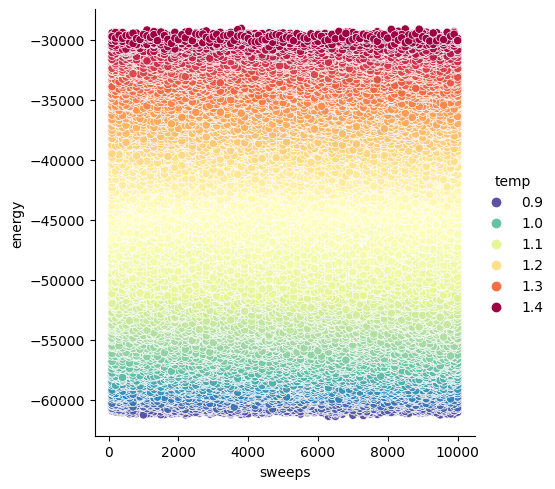

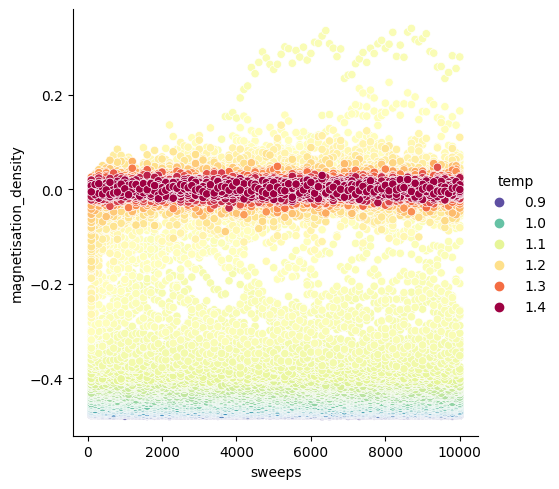

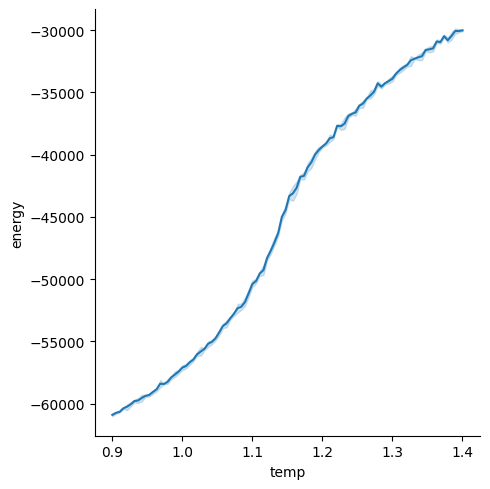

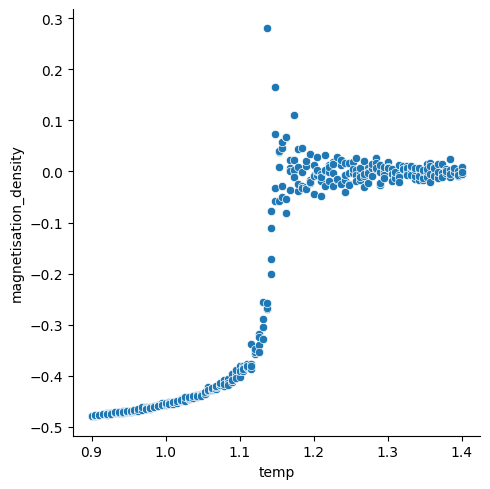

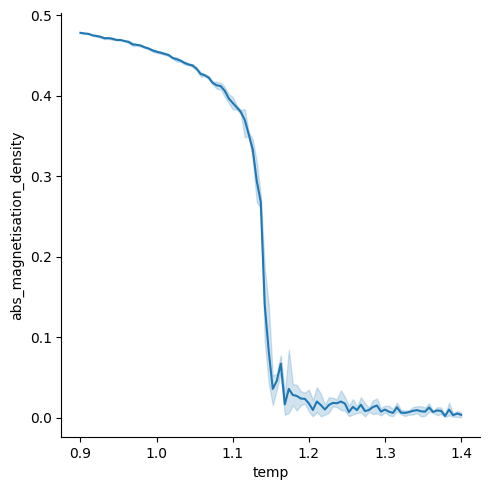

In [13]:
fig_evolve_energy_sweeps = sns.relplot(
    data=evolve_meas_df,
    x="sweeps",
    y="energy",
    hue="temp",
    palette="Spectral_r",
)
fig_evolve_energy_sweeps.savefig(SAVE_PATH / "fig_evolve_energy_sweeps.png")

fig_evolve_mag_dens_sweeps = sns.relplot(
    data=evolve_meas_df,
    x="sweeps",
    y="magnetisation_density",
    hue="temp",
    palette="Spectral_r",
)
fig_evolve_mag_dens_sweeps.savefig(SAVE_PATH / "fig_evolve_mag_dens_sweeps.png")

last_sweeps = evolve_meas_df[
    evolve_meas_df["sweeps"] == np.max(evolve_meas_df["sweeps"])
]

fig_evolve_energy_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="energy",
    # hue="beta",
    kind="line",
    # errorbar=None
)
fig_evolve_energy_temp.savefig(SAVE_PATH / "fig_evolve_energy_temp.png")

fig_evolve_mag_dens_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="magnetisation_density",
)
fig_evolve_mag_dens_temp.savefig(SAVE_PATH / "fig_evolve_mag_dens_temp.png")

fig_evolve_abs_mag_dens_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="abs_magnetisation_density",
    kind="line",
    # errorbar=None
)
fig_evolve_abs_mag_dens_temp.savefig(SAVE_PATH / "fig_evolve_abs_mag_dens_temp.png")

In [14]:
if c.plot_states:
    states_list = states.unensamble()
    temp_states = states_list[: c.n_temps]

In [15]:
if c.plot_states:

    @interact(value=0, min=0, max=len(temp_states))
    def update(i=(0, len(temp_states) - 1)):
        fig = temp_states[i].plot()
        fig.set_size_inches(10, 10)
        fig.dpi = 100

    ...

In [16]:
if c.check_thermalised:
    # Fit saturating decay times to quantifiably understand whether we have fully thermalised
    def fit_thermalisation(group):
        x = group["sweeps"]
        y = group["energy"]

        amplitude = np.max(y) - np.min(y)
        decay = np.max(x)
        offset = y.iloc[-1]

        params = SaturatingExponential.make_params()
        params["amplitude"].set(amplitude)
        params["decay"].set(decay, min=0, max=np.inf)
        params["c"].set(offset)

        fit = SaturatingExponential.fit(y, params, x=x)

        assert np.ptp(group["temp"]) == 0.0

        return pd.Series(
            {
                "temp": group["temp"].iloc[0],
                "therm_amplitude": fit.params["amplitude"].value,
                "therm_amplitude_sd": fit.params["amplitude"].stderr,
                "therm_decay": fit.params["decay"].value,
                "therm_decay_sd": fit.params["decay"].stderr,
                "therm_offset": fit.params["c"].value,
                "therm_offset_sd": fit.params["c"].stderr,
            }
        )

    evolve_meas_fit_df = evolve_meas_df.groupby("state_id", as_index=False).apply(
        fit_thermalisation
    )
    fig_evolve_therm_fit = sns.relplot(
        data=evolve_meas_fit_df,
        x="temp",
        y="therm_decay",
    )
    fig_evolve_therm_fit.savefig(SAVE_PATH / "fig_evolve_therm_fit.png")

    def _has_thermalised():
        high_temp_df = evolve_meas_fit_df[
            evolve_meas_fit_df["temp"] == evolve_meas_fit_df["temp"].max()
        ]
        therm_check_df = high_temp_df[
            high_temp_df["therm_decay"] > 4.0 * high_temp_df["therm_decay_sd"]
        ]

        # We have no data to check probably because system is very very thermalised
        # and thus has no data to fit to exponential
        if not len(therm_check_df):
            return True

        longest_decay = therm_check_df["therm_decay"].max()
        print(longest_decay)
        if evolve_meas_df["sweeps"].max() > 6.0 * longest_decay:
            return True

        return False

    has_thermalised = _has_thermalised()

    if not has_thermalised:
        raise RuntimeError("System has not fully thermalised!")

# Autocorrelation

In [17]:
if c.do_autocorrelation:

    @transforms(in_axes=(0, 0, None, None, None), out_axes=0)
    def get_autocorrelation(
        key: RNGKey, state: State, steps: int, sweeps_per_step: int, num_prints: int
    ) -> AutocorrelationData:
        keys = random.split(key, num=steps)

        def get_measurement_scan(state: State, x: RNGKey) -> tuple[State, Measurement]:
            rng_key = x
            state = state.evolve_sweeps(rng_key=rng_key, sweeps=sweeps_per_step)
            measurement = state.measure()

            return state, measurement

        scan = make_scan(
            tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
        )
        state, measurements = scan(f=get_measurement_scan, init=state, xs=keys)

        acorr_energy = acf(measurements.energy)
        acorr_mag_dens = acf(jnp.abs(measurements.magnetisation_density))

        sweeps = jnp.arange(acorr_energy.size) * sweeps_per_step

        # Fit exponential decay to find characteristic autocorrelation time
        def exponential_decay(x, tau):
            """
            f(x) = exp(- x / τ)
            """
            return jnp.exp(-x / tau)

        # Objective function to minimise
        def objective(params, x, y, weights):
            tau = params
            trial = exponential_decay(x, tau)
            residuals = y - trial
            weighted_residuals = weights * residuals

            return jnp.sum(weighted_residuals**2)

        energy_initial_params = jnp.asarray([float(sweeps_per_step)])
        # Noise at high x (low y) dominates fit.
        # Weigh by ordinate magnitude
        energy_weights = jnp.abs(acorr_energy)
        energy_decay_time = minimize(
            objective,
            x0=energy_initial_params,
            method="BFGS",
            args=(sweeps, acorr_energy, energy_weights),
        ).x[0]

        mag_dens_initial_params = jnp.asarray([float(sweeps_per_step)])
        mag_dens_weights = jnp.abs(acorr_mag_dens)
        mag_dens_decay_time = minimize(
            objective,
            x0=mag_dens_initial_params,
            method="BFGS",
            args=(sweeps, acorr_mag_dens, mag_dens_weights),
        ).x[0]

        return AutocorrelationData(
            state=state,
            steps=steps,
            sweeps_per_step=sweeps_per_step,
            sweeps=sweeps,
            energy=acorr_energy,
            magnetisation_density=acorr_mag_dens,
            energy_decay_time=energy_decay_time,
            magnetisation_density_decay_time=mag_dens_decay_time,
        )

    keys = k.shaped(states.transformation_shape)

    autocorrelation_timer = Stopwatch.start()
    ac_data = get_autocorrelation(
        keys, states, c.autocorrelation_steps, c.autocorrelation_sweeps_per_step, 10
    )
    ac_data.block_until_ready()

    autocorrelation_time = autocorrelation_timer.time()
    to_save["autocorrelation_time"] = autocorrelation_time
    print(f"Ran autocorrelation program in: {autocorrelation_time} sec.")

    eqx.tree_serialise_leaves(SAVE_PATH / "ac_data.eqx", ac_data)

In [18]:
if c.do_autocorrelation:
    ac_df = ac_data.to_df()
    ac_df["temp"] = beta_to_temp(ac_df["state.beta"], human=True)
    ac_df_expl = ac_df.explode(
        ["energy", "magnetisation_density", "sweeps"]
    ).infer_objects()

    ac_df_expl["energy_fit"] = np.exp(
        -ac_df_expl["sweeps"] / ac_df_expl["energy_decay_time"]
    )
    ac_df_expl["mag_dens_fit"] = np.exp(
        -ac_df_expl["sweeps"] / ac_df_expl["magnetisation_density_decay_time"]
    )

    display(ac_df)
    display(ac_df_expl)

    ac_df.reset_index().to_feather(SAVE_PATH / "ac_df.feather")
    ac_df_expl.reset_index().to_feather(SAVE_PATH / "ac_df_expl.feather")

In [19]:
if c.do_autocorrelation:
    fig_autocorrelation_energy = plt.figure()
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="energy",
        hue="temp",
        palette="Spectral_r",
        errorbar=None,
    )
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="energy_fit",
        hue="temp",
        palette="Spectral_r",
        ls="--",
        errorbar=None,
    )
    fig_autocorrelation_energy.savefig(SAVE_PATH / "fig_autocorrelation_energy.png")

    fig_autocorrelation_mag_dens = plt.figure()
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="magnetisation_density",
        hue="temp",
        palette="Spectral_r",
        errorbar=None,
    )
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="mag_dens_fit",
        hue="temp",
        palette="Spectral_r",
        ls="--",
        errorbar=None,
    )
    fig_autocorrelation_mag_dens.savefig(SAVE_PATH / "fig_autocorrelation_mag_dens.png")

    fig_autocorrelation_decay_times, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    sns.lineplot(
        data=ac_df,
        x="temp",
        y="energy_decay_time",
        ax=ax1,
    )
    sns.lineplot(
        data=ac_df,
        x="temp",
        y="magnetisation_density_decay_time",
        ax=ax2,
        color="orange",
    )
    plt.show()
    fig_autocorrelation_decay_times.savefig(
        SAVE_PATH / "fig_autocorrelation_decay_times.png"
    )

# Measure Equilibrium

In [20]:
if c.do_measure:

    @transforms(in_axes=(0, 0, None, None, None, None), out_axes=0)
    def measure_equilibrium(
        key: RNGKey, state: State, steps: int, num: int, sweeps: int, num_prints: int
    ) -> Measurement:
        def body_fun(carry: State, x: RNGKey):
            _rng_key = x
            measurements = carry.evolve_and_measure_multiple(
                rng_key=_rng_key, num=num, sweeps=sweeps
            )

            return carry, measurements

        keys = random.split(key=key, num=steps)
        scan = make_scan(
            tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
        )
        state, measurements = scan(f=body_fun, init=state, xs=keys)

        return measurements

    keys = k.shaped(states.transformation_shape)

    measurement_timer = Stopwatch.start()
    equil_measurements = measure_equilibrium(
        keys,
        states,
        c.measure_equilibrium_steps,
        c.measure_equilibrium_num,
        c.measure_equilibrium_sweeps_per_step,
        10,
    )
    equil_measurements.block_until_ready()

    measurement_time = measurement_timer.time()
    to_save["measurement_time"] = measurement_time
    print(f"Ran measurement program in: {measurement_time} sec.")

    eqx.tree_serialise_leaves(SAVE_PATH / "equil_measurements.eqx", equil_measurements)

In [21]:
if c.do_measure:
    _eq_df = equil_measurements.to_df()
    eq_df = _eq_df.explode(_eq_df.columns.tolist()).infer_objects()
    eq_df

In [22]:
if c.do_measure:
    # Create two dataframes of different 'shapes'
    # meas_df: holds data that is defined on every state
    # sample_df: holds data that is summarised across particular systems (those with same state_id)
    # temp_df: holds data that is summarised across all systems of a particular temperature
    def find_bootstrap_std_err(data):
        bootstraps = bootstrap(jnp.asarray(data), jnp.var, num_samples=32, key=k.new)
        std = jnp.std(bootstraps)
        return std.item()

    meas_df = eq_df.copy()
    meas_df["natural_temperature"] = beta_to_temp(meas_df["beta"], human=True)
    meas_df["temperature"] = beta_to_temp(meas_df["beta"], human=False)
    meas_df["abs_magnetisation_density"] = np.abs(meas_df["magnetisation_density"])

    temp_df = pd.DataFrame()

    # Energy - Summarised
    temp_group = meas_df.groupby(["natural_temperature", "temperature", "beta"])
    temp_df["energies_mean"] = temp_group["energy"].mean()
    temp_df["energies_var"] = temp_group["energy"].var()
    temp_df["energies_var_sd"] = temp_group["energy"].apply(find_bootstrap_std_err)
    temp_df["energies_var_var"] = temp_df["energies_var_sd"] ** 2

    # Magnetisation Density - Summarised
    temp_df["mag_dens_mean"] = temp_group["magnetisation_density"].mean()
    temp_df["mag_dens_var"] = temp_group["magnetisation_density"].var()
    temp_df["mag_dens_var_sd"] = temp_group["magnetisation_density"].apply(
        find_bootstrap_std_err
    )
    temp_df["mag_dens_var_var"] = temp_df["mag_dens_var_sd"] ** 2

    temp_df["mag_dens_abs_mean"] = temp_group["abs_magnetisation_density"].mean()
    temp_df["mag_dens_abs_var"] = temp_group["abs_magnetisation_density"].var()
    temp_df["mag_dens_abs_var_sd"] = temp_group["abs_magnetisation_density"].apply(
        find_bootstrap_std_err
    )
    temp_df["mag_dens_abs_var_var"] = temp_df["mag_dens_abs_var_sd"] ** 2

    # index
    temp_df = temp_df.reset_index()

    # Heat Capacity
    temp_df["heat_cap_fluctuation"] = temp_df["energies_var"] / (
        constants.Boltzmann * np.square(temp_df["temperature"].astype(np.float128))
    ).astype(np.float64)
    temp_df["heat_cap_gradient"] = np.gradient(
        temp_df["energies_mean"], temp_df["temperature"].astype(np.float128)
    ).astype(np.float64)

    # Magnetic Susceptibility
    if not c.interaction_external_field:
        temp_df["mag_sus_fluctuation"] = (
            states.size
            * constants.Boltzmann
            * temp_df["beta"]
            * temp_df["mag_dens_abs_var"]
        )
        temp_df["mag_sus_gradient"] = states.size * np.abs(
            np.gradient(
                temp_df["mag_dens_abs_mean"], temp_df["temperature"].astype(np.float128)
            ).astype(np.float64)
        )

    # Binder cumulant
    sample_df = pd.DataFrame()

    meas_df["mag_1"] = np.abs(eq_df["magnetisation_density"])
    meas_df["mag_2"] = np.power(eq_df["magnetisation_density"], 2)
    meas_df["mag_4"] = np.power(eq_df["magnetisation_density"], 4)

    sample_group = meas_df.groupby("state_id")

    sample_df["mag_1_mean"] = meas_df.groupby("state_id")["mag_1"].mean()
    sample_df["mag_2_mean"] = meas_df.groupby("state_id")["mag_2"].mean()
    sample_df["mag_4_mean"] = meas_df.groupby("state_id")["mag_4"].mean()

    sample_df["binder_2"] = 1 - sample_df["mag_2_mean"] / np.square(
        sample_df["mag_1_mean"]
    )
    sample_df["binder_4"] = 1.0 / 3.0 - sample_df["mag_4_mean"] / (
        3.0 * np.square(sample_df["mag_2_mean"])
    )

    sample_df["natural_temperature"] = sample_group["natural_temperature"].first()
    sample_df["temperature"] = sample_group["temperature"].first()
    sample_df["beta"] = sample_group["beta"].first()

    meas_df.reset_index().to_feather(SAVE_PATH / "meas_df.feather")
    temp_df.reset_index().to_feather(SAVE_PATH / "temp_df.feather")
    sample_df.reset_index().to_feather(SAVE_PATH / "sample_df.feather")

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [23]:
meas_df

NameError: name 'meas_df' is not defined

In [ ]:
if c.do_measure:
    fig_measure_energy_temp = sns.relplot(
        data=meas_df,
        x="natural_temperature",
        y="energy",
        kind="line",
    )
    fig_measure_energy_temp.savefig(SAVE_PATH / "fig_measure_energy_temp.png")

    fig_measure_mag_dens_temp = sns.relplot(
        data=meas_df,
        x="natural_temperature",
        y="magnetisation_density",
        # kind="line",
    )
    fig_measure_mag_dens_temp.savefig(SAVE_PATH / "fig_measure_mag_dens_temp.png")

    fig_measure_abs_mag_dens_temp = sns.relplot(
        data=meas_df,
        x="natural_temperature",
        y="abs_magnetisation_density",
        kind="line",
    )
    fig_measure_abs_mag_dens_temp.savefig(
        SAVE_PATH / "fig_measure_abs_mag_dens_temp.png"
    )

In [ ]:
if c.do_measure:
    fig_measure_heat_cap_fluctuation_temp = sns.relplot(
        data=temp_df,
        x="natural_temperature",
        y="heat_cap_fluctuation",
        kind="line",
    )
    fig_measure_heat_cap_fluctuation_temp.savefig(
        SAVE_PATH / "fig_measure_heat_cap_fluctuation_temp.png"
    )

    fig_measure_heat_cap_gradient_temp = sns.relplot(
        data=temp_df,
        x="natural_temperature",
        y="heat_cap_gradient",
        kind="line",
    )
    fig_measure_heat_cap_gradient_temp.savefig(
        SAVE_PATH / "fig_measure_heat_cap_gradient_temp.png"
    )

    if not c.interaction_external_field:
        fig_measure_mag_sus_fluctuation_temp = sns.relplot(
            data=temp_df,
            x="natural_temperature",
            y="mag_sus_fluctuation",
            kind="line",
        )
        fig_measure_mag_sus_fluctuation_temp.savefig(
            SAVE_PATH / "fig_measure_mag_sus_fluctuation_temp.png"
        )

        fig_measure_mag_sus_gradient_temp = sns.relplot(
            data=temp_df,
            x="natural_temperature",
            y="mag_sus_gradient",
            kind="line",
        )
        fig_measure_mag_sus_gradient_temp.savefig(
            SAVE_PATH / "fig_measure_mag_sus_gradient_temp.png"
        )

In [ ]:
if c.do_measure:
    fig_measure_binder_2 = sns.relplot(
        data=sample_df,
        x="natural_temperature",
        y="binder_2",
        kind="line",
    )
    fig_measure_binder_2.savefig(SAVE_PATH / "fig_measure_binder_2.png")

    fig_measure_binder_4 = sns.relplot(
        data=sample_df,
        x="natural_temperature",
        y="binder_4",
        kind="line",
    )
    fig_measure_binder_4.savefig(SAVE_PATH / "fig_measure_binder_4.png")

In [ ]:
with open(SAVE_PATH / "saved_variables.json", "w") as f:
    json.dump(
        to_save, f, indent=4, sort_keys=True, ensure_ascii=False, cls=NumpyEncoder
    )